# **Домашняя работа по ТВИМС** 

## Учебный ноутбук с R(t) моделями

---

### **Выполнил**:  
**Вольхин Данил Федорович**

### **Email**:  
[dfvolkhin@edu.hse.ru](mailto:dfvolkhin@edu.hse.ru)

### **Дата**:  
**30 октября 2024**

---

😊 Приятного просмотра 😊

# Учебник по генеративным моделям

В этой лекции вы узнаете:

* Как строить генеративные модели, которые учитывают имеющиеся у нас знания о процессе генерации данных
* Как можно применить формулу Байеса для обратного вывода от наблюдаемых данных к ненаблюдаемым скрытым причинам
* Как моделировать изменяющиеся во времени процессы
* Как итеративно улучшать модель

В этом блокноте объясняется модель, на которой работает https://rt.live с ее прогнозом эффективного числа воспроизводства. Она основана на [версии 1.0.0](https://github.com/rtcovidlive/covid-model/commit/50bf8e4ace5b973b3d323f058ad613d4b02f4c2f) модели.

## Что такое Rt?
$R_0$ («R-ноль») описывает фактор воспроизводства заболевания — т. е. скольким другим людям один инфицированный человек передает болезнь. Если это количество больше 1, то у нас на руках эпидемия, как в случае с COVID-19.

Однако $R_0$ предполагает, что не предпринимаются никакие контрмеры для сдерживания распространения вируса. Таким образом, более важной мерой для отслеживания является $R_e(t)$ — изменяющийся во времени эффективный фактор воспроизводства, т. е. сколько людей заражает один человек в определенный день $t$.

По мере введения мер изоляции и социального дистанцирования мы ожидаем, что это количество снизится, в идеале ниже критического количества 1, потому что тогда со временем болезнь просто сойдет на нет.

Обычно мы извлекаем $R_e(t)$ из чего-то вроде [модели SIR (восприимчивый-инфицированный-выздоровевший)](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) или SEIR (которая добавляет категорию подверженных воздействию), которые являются классическими эпидемиологическими моделями отсеков.

Модель SIR — это то, что `rt.live` использовал в начале. Однако модели SIR/SEIR также являются лишь приближениями к реальной вещи и содержат довольно много встроенных предположений. Текущая модель проще и делает меньше предположений. Кроме того, модель SIR описывается как ODE, что вызывает различные технические проблемы. Решение ODE требует довольно много времени, и хотя существуют приближения в замкнутой форме, которые работают быстрее, мы обнаружили, что они довольно ненадежны.

Вместо этого текущая модель использует простую генеративную логику для объяснения того, как начальный пул инфицированных людей распространяет болезнь в каждый момент времени в соответствии с текущим фактором воспроизводства.

## Генеративная модель

Нам нужен пакет из репозитория rtlive для загрузки данных и получения наших дистрибутивов.

In [1]:
# ANSI коды для цветов текста
RED = "\033[31m"
GREEN = "\033[32m"
YELLOW = "\033[33m"
BLUE = "\033[34m"
RESET = "\033[0m"  # сброс цветов до стандартных

# Импорт библиотек

In [2]:
# Импорт библиотек
print(f"{YELLOW}"+60*"-"+f"{RESET}")
print(f"Библиотеки: \n")
import os
import sys
import platform
from copy import deepcopy
print(f"python: {GREEN}{platform.python_version()}{RESET} ")

import arviz as az
print(f"arviz: {GREEN}{az.__version__}{RESET} ")
import matplotlib
import matplotlib.pyplot as plt
print(f"matplotlib: {GREEN}{matplotlib.__version__}{RESET}")
import numpy as np
print(f"numpy: {GREEN}{np.__version__}{RESET}")
import pandas as pd
print(f"pandas: {GREEN}{pd.__version__}{RESET}")
import pymc3 as pm
print(f"pymc3: {GREEN}{pm.__version__}{RESET} ")
import seaborn as sns
print(f"seaborn: {GREEN}{sns.__version__}{RESET}")
from IPython.display import Markdown, display
import theano
print(f"theano: {GREEN}{theano.__version__}{RESET}")
import theano.tensor as tt

sns.set_context("talk")
print(f"{YELLOW}"+60*"-"+f"{RESET}")
print(f"Кастомные функции и библиотеки: \n")
import covid.data
import covid.patients
from covid.data import summarize_inference_data, load_owid_covid_data
from covid.models.generative import GenerativeModel
from covid.patients import get_delay_distribution
from scipy import stats
print(f"{BLUE}covid.data{RESET}")
print(f"{BLUE}covid.patients{RESET}")
print(f"{BLUE}covid.models.generative{RESET}")
print(f"{BLUE}load_owid_covid_data{RESET}")
print(f"{BLUE}summarize_inference_data{RESET}")
print(f"{BLUE}get_delay_distribution{RESET}")
print(f"{BLUE}GenerativeModel{RESET}")
print(f"{YELLOW}"+60*"-"+f"{RESET}")

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

------------------------------------------------------------
Библиотеки: 

python: 3.6.15 
arviz: 0.11.1 
matplotlib: 3.3.4
numpy: 1.19.5
pandas: 1.1.5


C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\theano\gpuarray\dnn.py:196: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  "Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\theano\gpuarray\__init__.py", line 263, in <module>
    use(config.device)
  File "C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\theano\gpuarray\__init__.py", line 250, in use
    init_dev(device, preallocate=preallocate)
  File "C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\theano\gpuarray\__init__.py", line 136, in init_dev
    context.cudnn_handle = dnn._make_handle(context)
  File "C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\theano\gpuarray\dnn.py", line 124, in _make_handle
    cudnn = _dnn_li

pymc3: 3.10.0 
seaborn: 0.11.2
theano: 1.0.11
------------------------------------------------------------
Кастомные функции и библиотеки: 

covid.data
covid.patients
covid.models.generative
load_owid_covid_data
summarize_inference_data
get_delay_distribution
GenerativeModel
------------------------------------------------------------


# Задаем параметры

In [3]:
# Параметры для инференса моделей
def sampler_kwargs(
    chains: int = 1,
    cores: int = 1,
    return_inferencedata: bool = True,
    tune: int = None,
    draws: int = None
):
    if tune is None and draws is None:
        return {
            "chains": 1,
            "cores": 1,
            "return_inferencedata": return_inferencedata,
            "random_seed": 42,
        }
    else:
        return {
            "chains": 1,
            "cores": 1,
            "return_inferencedata": return_inferencedata,
            "random_seed": 42,
            "tune": tune,
            "draws": draws
        }

In [4]:
# В предыдущей выборке GaussianRandomWalk есть ошибка,
# эта обезьяна-патчит исправление. Это должно быть исправлено скоро в PyMC3.
def _random(self, sigma, mu, size, sample_shape):
    """Реализуйте гауссовское случайное блуждание как кумулятивную сумму нормалей."""
    if size[len(sample_shape)] == sample_shape:
        axis = len(sample_shape)
    else:
        axis = len(size) - 1
    rv = stats.norm(mu, sigma)
    data = rv.rvs(size).cumsum(axis=axis)
    data = np.array(data)
    if len(data.shape) > 1:
        for i in range(data.shape[0]):
            data[i] = data[i] - data[i][0]
    else:
        data = data - data[0]
    return data


pm.GaussianRandomWalk._random = _random

In [5]:
covid.data.np = np
%config InlineBackend.figure_format = 'retina'

# Загрузка данных

In [7]:
df = load_owid_covid_data(file_path='./data/owid-covid-data.csv', filter_n_days_100=2)
df.head()

country confirmed  new_cases  days_since_100
date                                                        
2020-03-28  Afghanistan       106         15               0
2020-03-29  Afghanistan       114          8               1
2020-03-30  Afghanistan       114          0               2
2020-03-31  Afghanistan       166         52               3
2020-04-01  Afghanistan       192         26               4

In [8]:
countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 > 0)]
df.head()

country confirmed  new_cases  days_since_100
date                                                        
2020-03-29  Afghanistan       114          8               1
2020-03-30  Afghanistan       114          0               2
2020-03-31  Afghanistan       166         52               3
2020-04-01  Afghanistan       192         26               4
2020-04-02  Afghanistan       235         43               5

In [9]:
df[df['new_cases'] <= 0]

country confirmed  new_cases  days_since_100
date                                                        
2020-03-30  Afghanistan       114          0               2
2020-04-11  Afghanistan       521          0              14
2020-04-30  Afghanistan      1827          0              33
2020-05-03  Afghanistan      2469          0              36
2020-05-04  Afghanistan      2469          0              37
...                 ...       ...        ...             ...
2022-07-01     Zimbabwe    255586          0             765
2022-07-02     Zimbabwe    255586          0             766
2022-07-03     Zimbabwe    255586          0             767
2022-07-07     Zimbabwe    255805          0             771
2022-07-13     Zimbabwe    255981          0             777

[36178 rows x 4 columns]

In [10]:
df.country.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

Хотя раньше мы рассматривали кумулятивные подтвержденные случаи, имеет смысл рассматривать новые ежедневные случаи. Это также обходит проблему, что все наши предыдущие модели допускали снижение случаев со временем, в то время как процесс генерации данных не допускал этого.

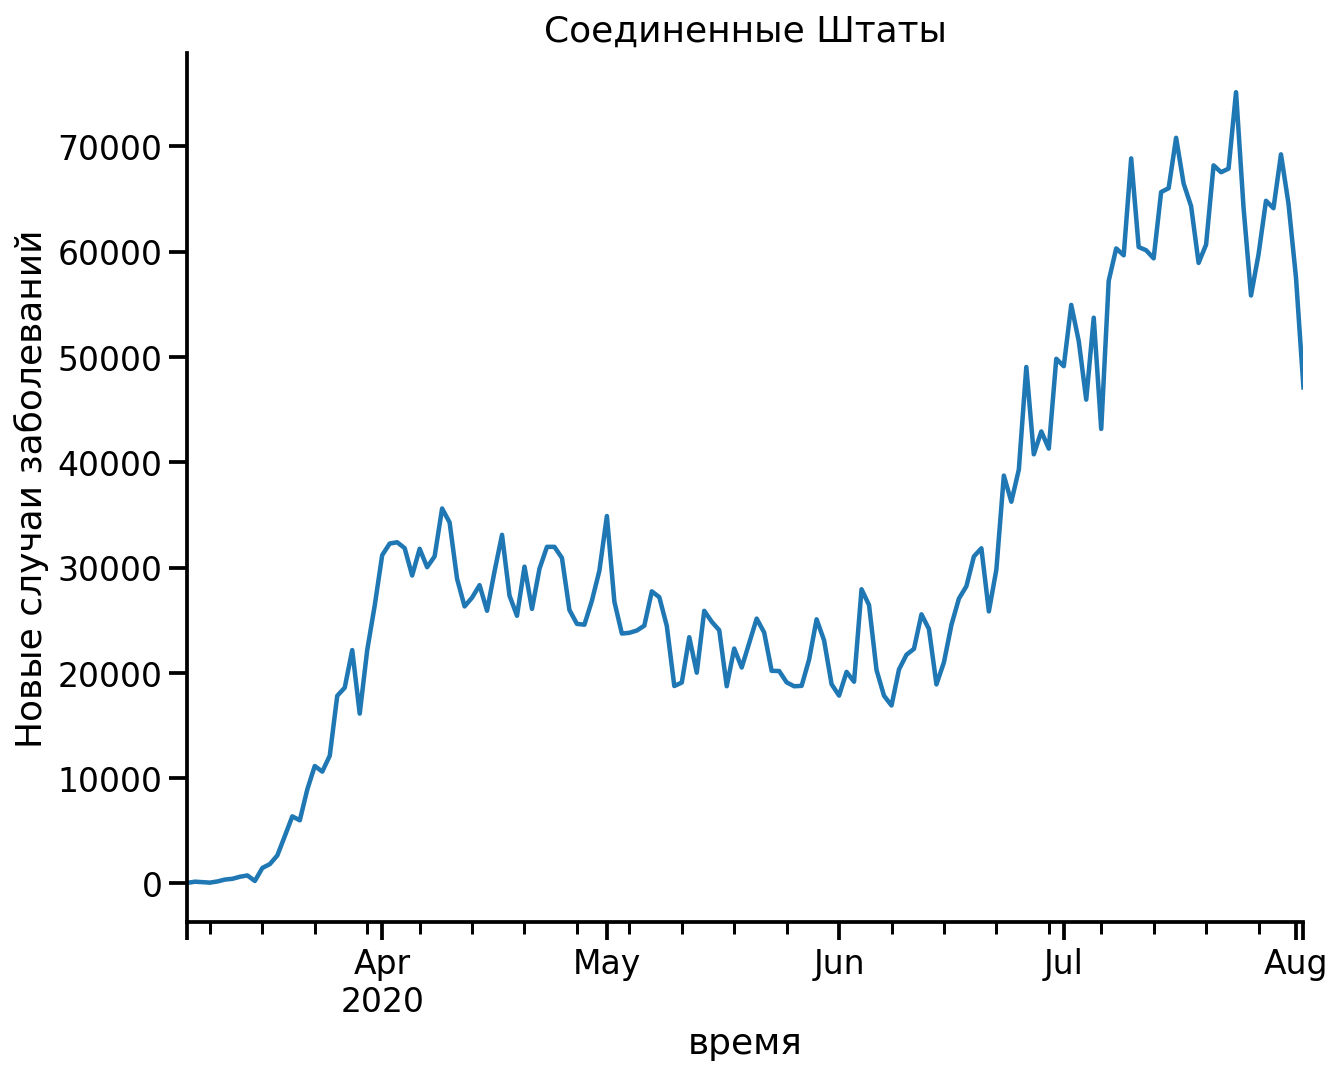

In [11]:
country = "United States"
df_country = df.loc[lambda x: (x.country == country)].iloc[1:151]

fig, ax = plt.subplots(figsize=(10, 8))
new_cases = df_country.new_cases
new_cases.plot(ax=ax)
ax.set(ylabel="Новые случаи заболеваний", xlabel='время', title='Соединенные Штаты')
sns.despine()

In [12]:
print("Any NaN:", new_cases.isna().any())

Any NaN: False


Предположим, что для идеальной болезни мы начинаем с одного инфицированного пациента (первичная инфекция) в день $0$, который заразен только один день и в этот день заражает 2 человек (вторичная инфекция), которые заболевают на следующий день. Таким образом, эта болезнь имеет фактор воспроизводства $R_0$, равный 2. Мы могли бы записать, что в день $t$ число вновь инфицированных $y_t$ равно:

$$ y_t = y_{t-1} \cdot R_0 $$

Довольно просто. Эта логика порождает классическую модель экспоненциального роста, которую мы видим в эпидемиях:

In [13]:
# Код оптимизирован для удобства чтения, а не скорости
# Задаем количество дней, которое будем считать по модели
n_days = 10
# Инициализируем массив длиной по количеству дней
ts = np.arange(n_days)
# Определяем константное значение репродуктивного числа
R0 = 2
# Инициализируем массив длиной времени для значений количества новых случаев
y = np.zeros(n_days)
# Рассчитываем по формуле каждое следующее значение новоых случаев
y[0] = 1  # Начинаем с 1 инфицированного
for t in ts[1:]:
    y[t] = y[t - 1] * R0

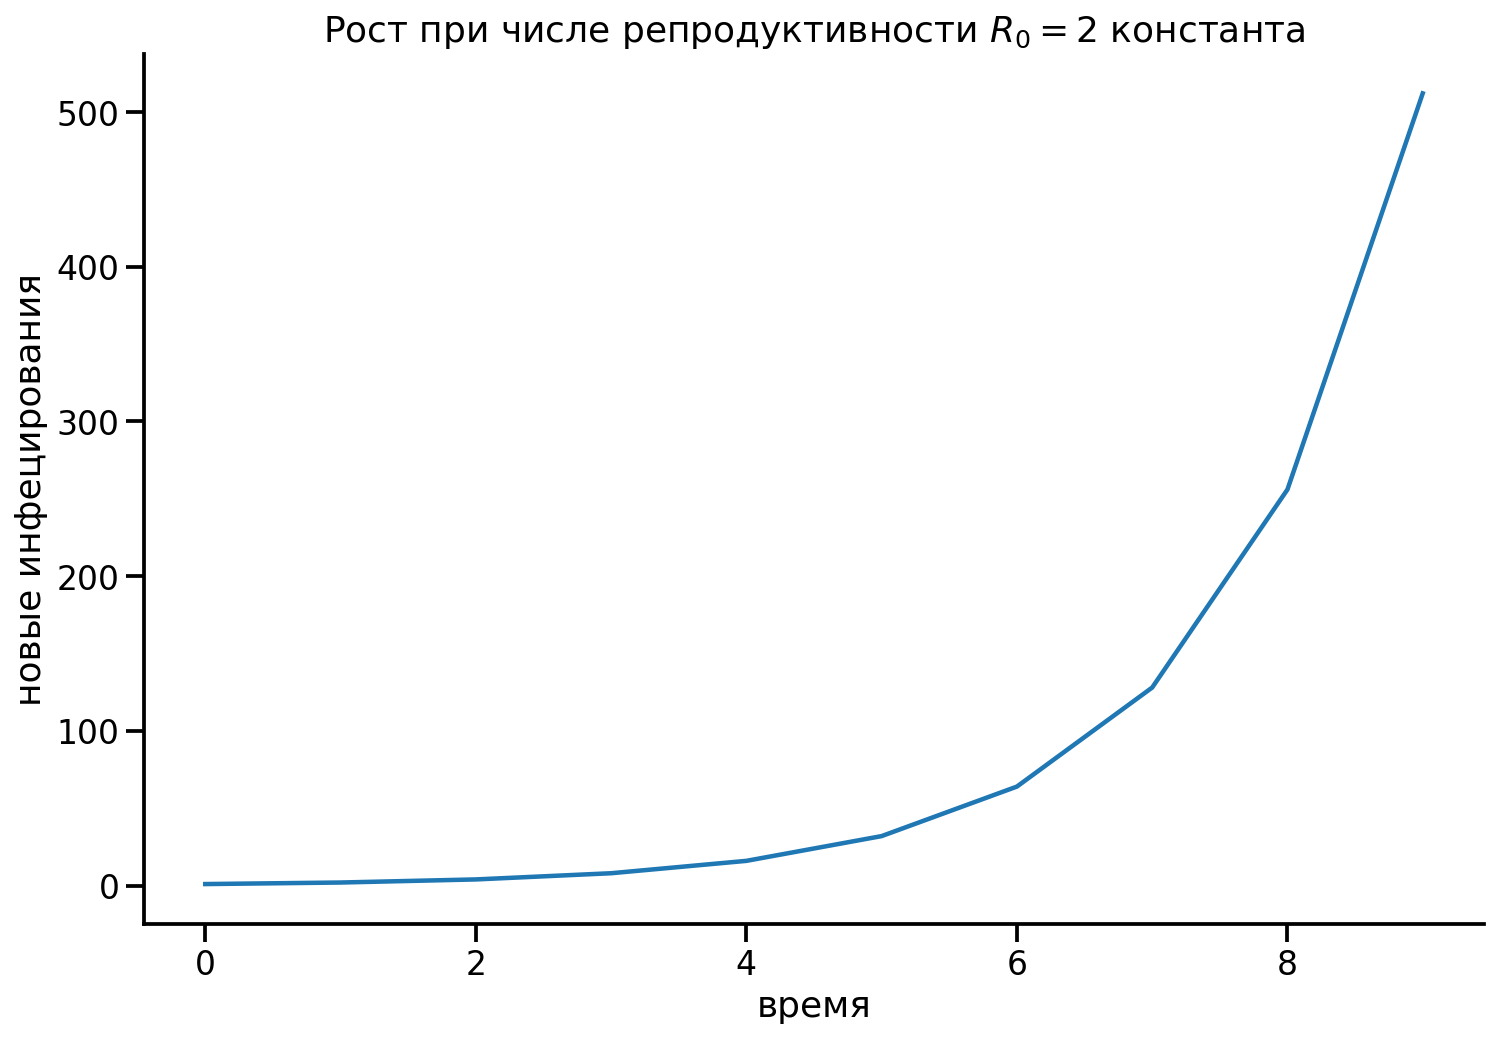

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, y)
ax.set(
    xlabel="время",
    ylabel="новые инфецирования",
    title="Рост при числе репродуктивности $R_0 = 2$ константа",
)
sns.despine();

## Построение модели

Чтобы встроить эту рекурсивную природу в `PyMC3`, нам нужно создать цикл внутри нашей модели. Поскольку PyMC3 компилирует все в `theano`, мы не можем просто использовать цикл Python. К счастью, `theano` имеет собственную логику цикла в форме `scan`. К сожалению, синтаксис довольно запутанный. Не беспокойтесь слишком сильно обо всех отдельных аргументах, но обратите внимание, что наша генеративная логика реализована как лямбда-функция, переданная в `fn`. `scan` затем будет проходить по `sequences` и обновлять `y` на каждой итерации.

Здесь мы также впервые используем `Deterministic`. Все, что он делает, это сохраняет переменную вашей модели в трассировке. Если у вас есть какое-либо выражение, состоящее из других случайных величин, часто удобно записывать их вместе с апостериорными параметрами.

In [15]:
len_observed = len(new_cases)


# Создаем модель с использованием PyMC (probabilistic programming) для моделирования R0
with pm.Model() as model_r0:
    
    # Задаем начальное значение репродуктивного числа (r0), которое может быть исключительно больше нуля
    # Используем логнормальное распределение для инициализации r0, где среднее 0.2, и дисперсия 0.1
    r0 = pm.Lognormal("r0", np.log(1.0), 0.1)

    # Определяем начальную популяцию для заражения
    # Используем экспоненциальное распределение с начальным значением 0.01
    seed = pm.Exponential("seed", 0.01)
    
    # Создаем начальный массив y0 для хранения динамики инфекций
    # Массив инициализируется нулями и имеет длину равную числу наблюдений
    y0 = tt.zeros(len_observed)

    # Устанавливаем первый элемент массива y0 как seed, что означает начальную популяцию
    y0 = tt.set_subtensor(y0[0], seed)

    # Реализуем рекурсивный алгоритм для вычисления прогрессии инфекций с использованием функции scan
    # Каждый последующий элемент инфекции y[t] будет равен значению предыдущей инфекции, умноженному на r0
    outputs, _ = theano.scan(
        fn=lambda t, y, r0: tt.set_subtensor(y[t], r0 * y[t - 1]),
        sequences=[tt.arange(1, len_observed)],  # перебор по временным точкам, начиная с 1
        outputs_info=y0,  # начальное состояние инфекции
        non_sequences=r0,  # передаем r0 как неизменяемый параметр функции
        n_steps=len_observed - 1  # количество шагов, чтобы охватить все наблюдения
    )

    # Создаем детерминированную переменную infections, которая хранит прогнозиуемую прогрессию инфекции на последнем шаге
    infections = pm.Deterministic("infections", outputs[-1])

    # Ограничиваем значения infections, чтобы избежать неконтролируемого роста инфекций
    # В частности, ограничиваем их диапазоном от 0 до 10 000 000
    infections = tt.clip(infections, 0, 10_000_000)
    
    # Определяем функцию правдоподобия (Likelihood) с использованием отрицательного биномиального распределения
    # "obs" — наблюдаемые значения, которые сравниваются с предсказанными инфекциями
    # Alpha задается случайной величиной из гамма-распределения со средним значением 6 и стандартным отклонением 1
    # observed=new_cases — реальные данные о количестве новых случаев заражения
    pm.NegativeBinomial(
        "obs", infections, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=new_cases
    )

In [16]:
with model_r0:
    prior_pred_r0 = pm.sample_prior_predictive()

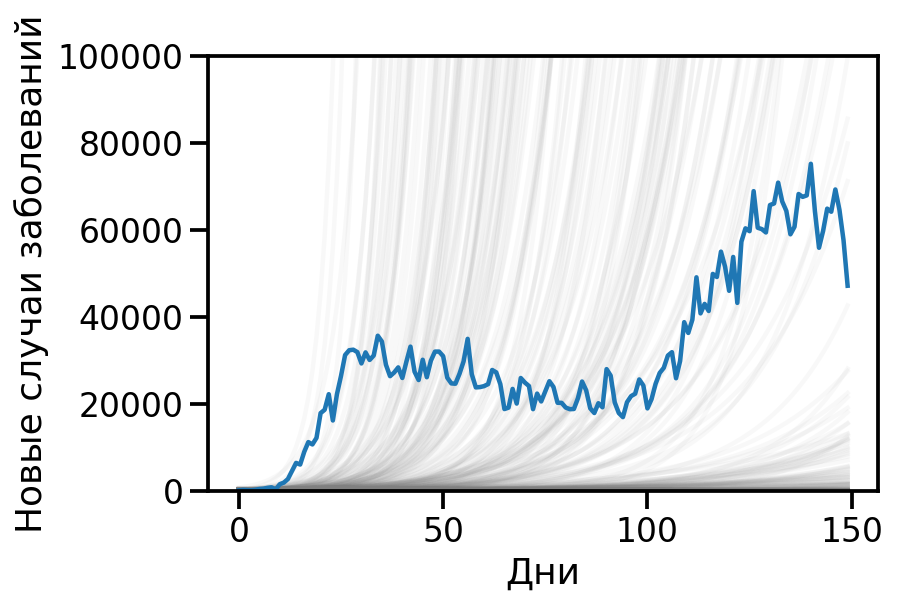

In [17]:
plt.plot(prior_pred_r0["infections"].T, color="0.5", alpha=0.05)
plt.plot(new_cases.values)
plt.ylim(0, 100_000)
plt.xlabel("Дни")
plt.ylabel("Новые случаи заболеваний");

In [18]:
with model_r0:
    _kwargs = sampler_kwargs()
    trace = pm.sample(**_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, r0]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 53 seconds.
The acceptance probability does not match the target. It is 0.9013509311245206, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


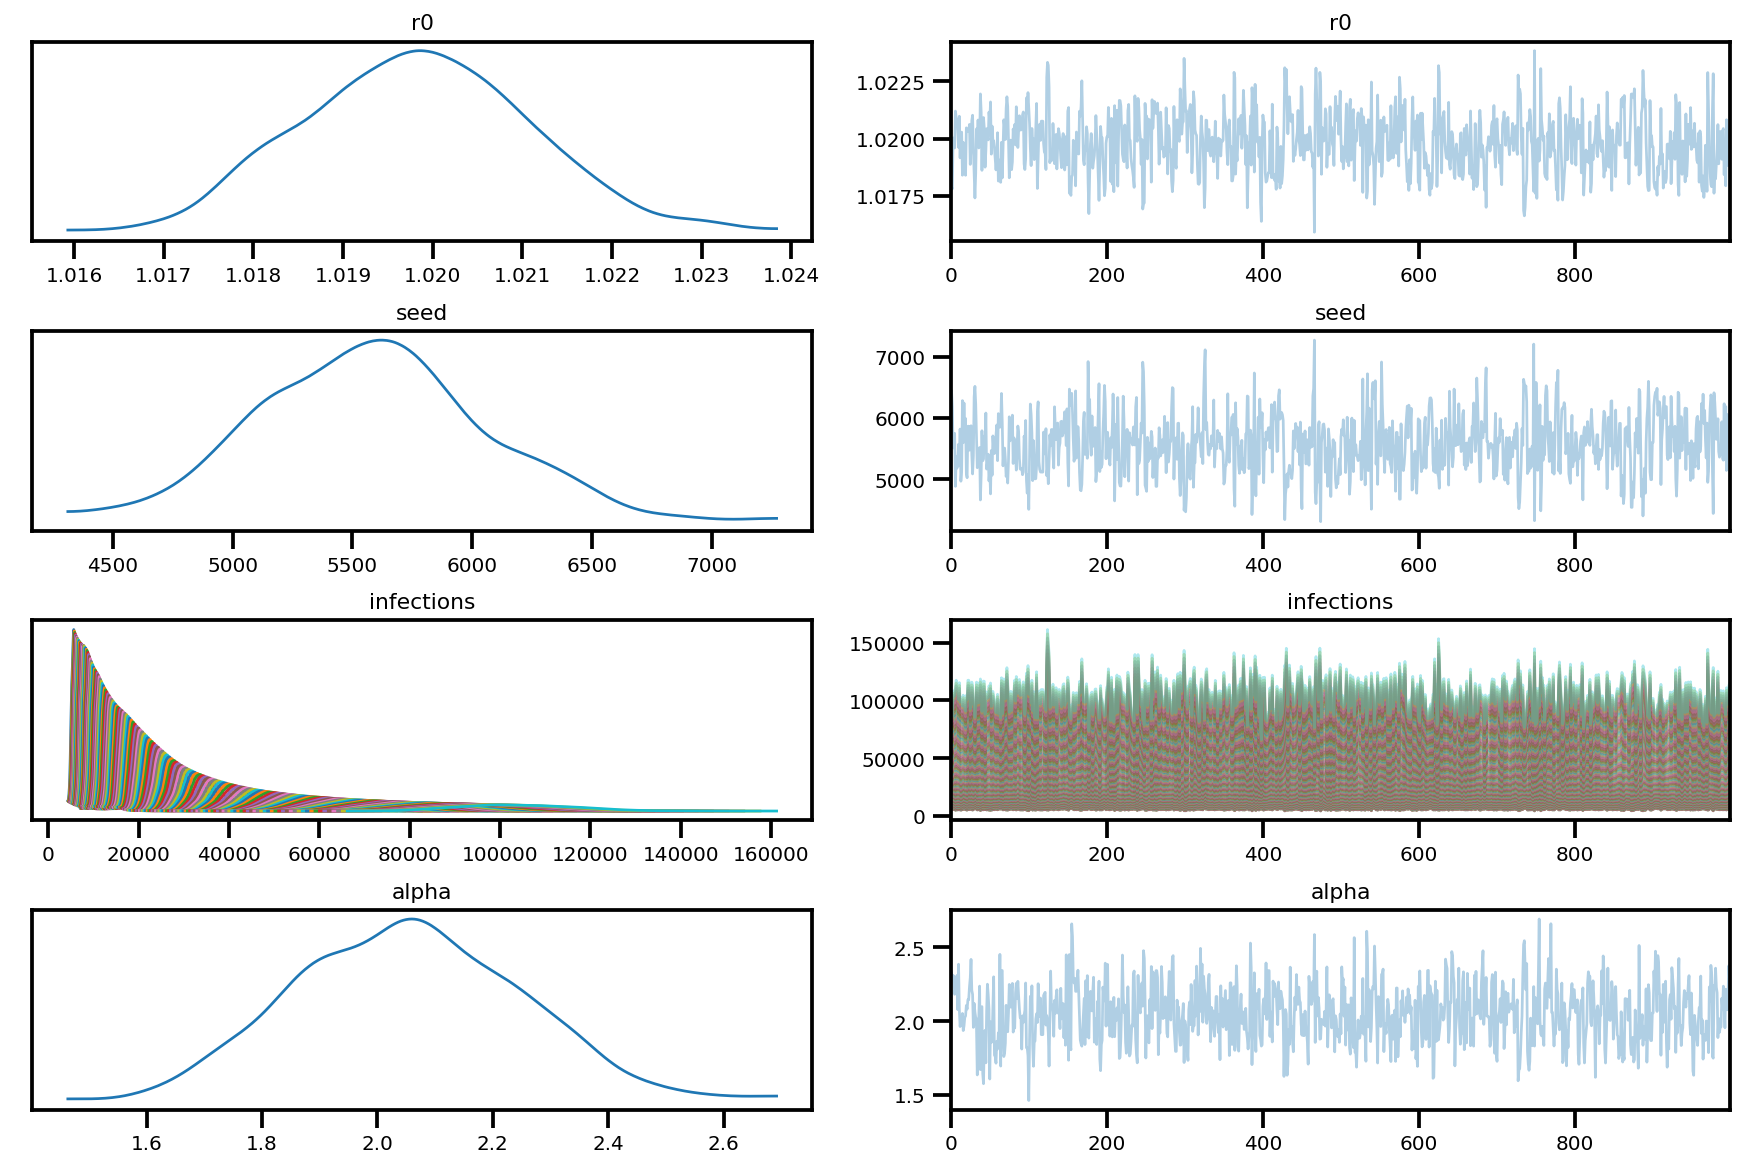

In [19]:
az.plot_trace(trace, compact=True);

C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\pymc3\sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


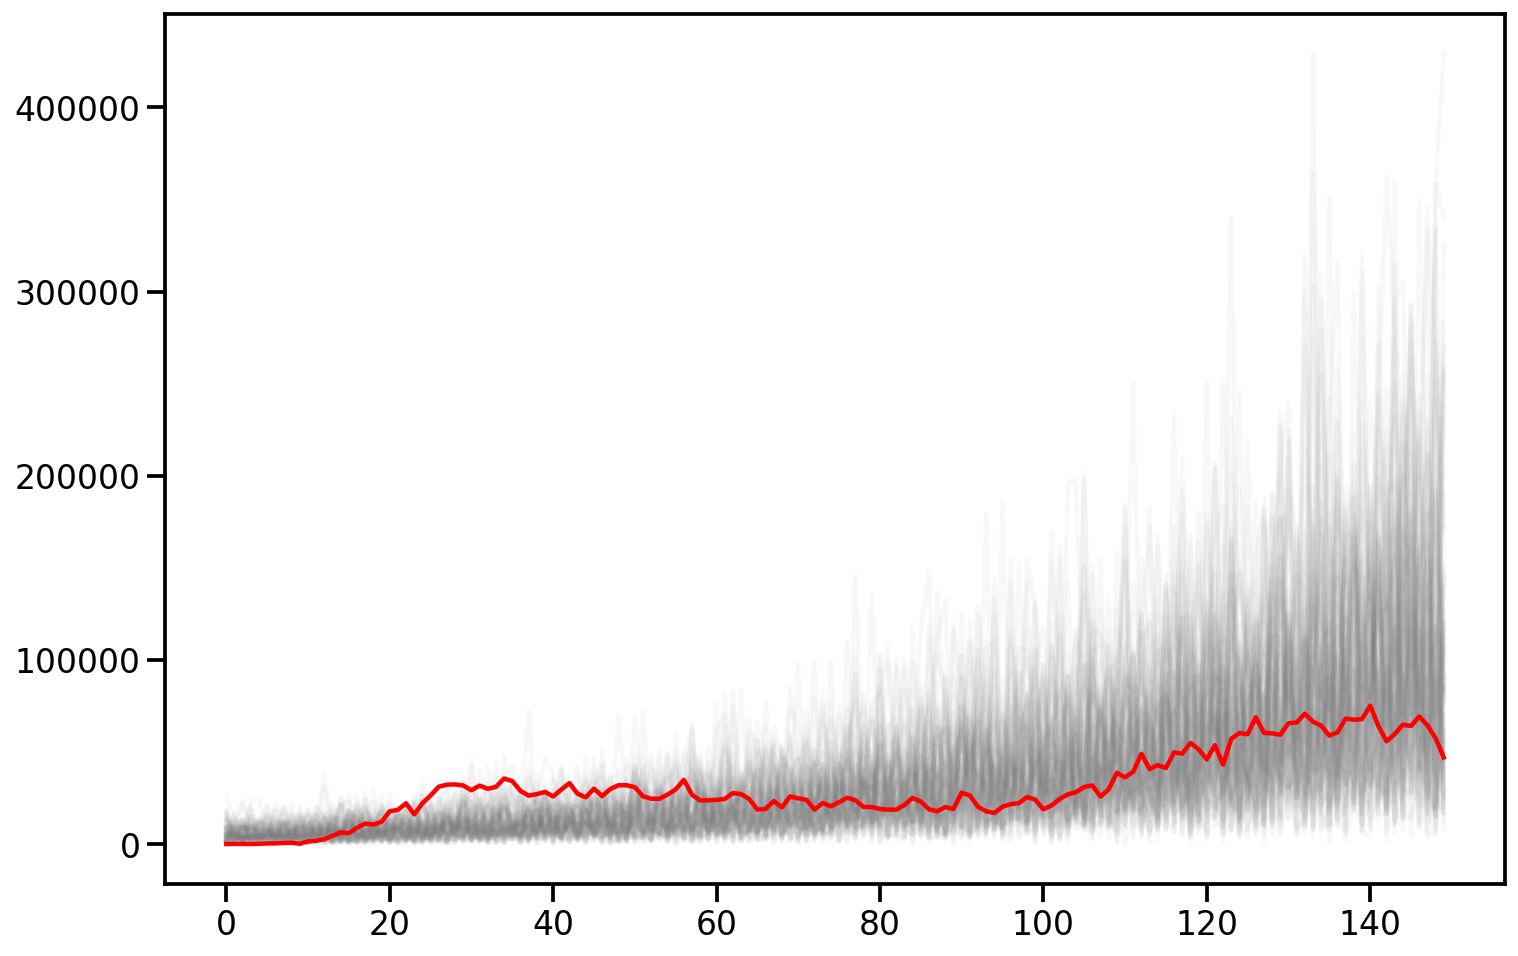

In [20]:
with model_r0:
    post_pred_r0 = pm.sample_posterior_predictive(trace.posterior, samples=100)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_pred_r0["obs"].T, color="0.5", alpha=0.05)
ax.plot(new_cases.values, color="r");

## Изменяющееся во времени воспроизведение

Однако, как мы уже обсуждали, нас больше интересует эффективная скорость воспроизведения как функция времени $R_e(t)$. Мы можем просто переключить это в нашу идеализированную генеративную модель:

$$ y_t = y_{t-1} \cdot R_e(t) $$

In [21]:
# Задаем количество дней
n_days = 10
# Массив длиной количеству дней
ts = np.arange(n_days)
# Задаем массив значений репродуктивного числа на уменьшение от 2 к 1 длиной количеств дней
Rt = np.linspace(2, 1, n_days)
# Задаем массив значений числа заболевших
y = np.zeros(n_days)
# По формуле рассчитываем число заболеваний
y[0] = 1  # starting with 1 infected
for t in ts[1:]:
    y[t] = y[t - 1] * Rt[t]

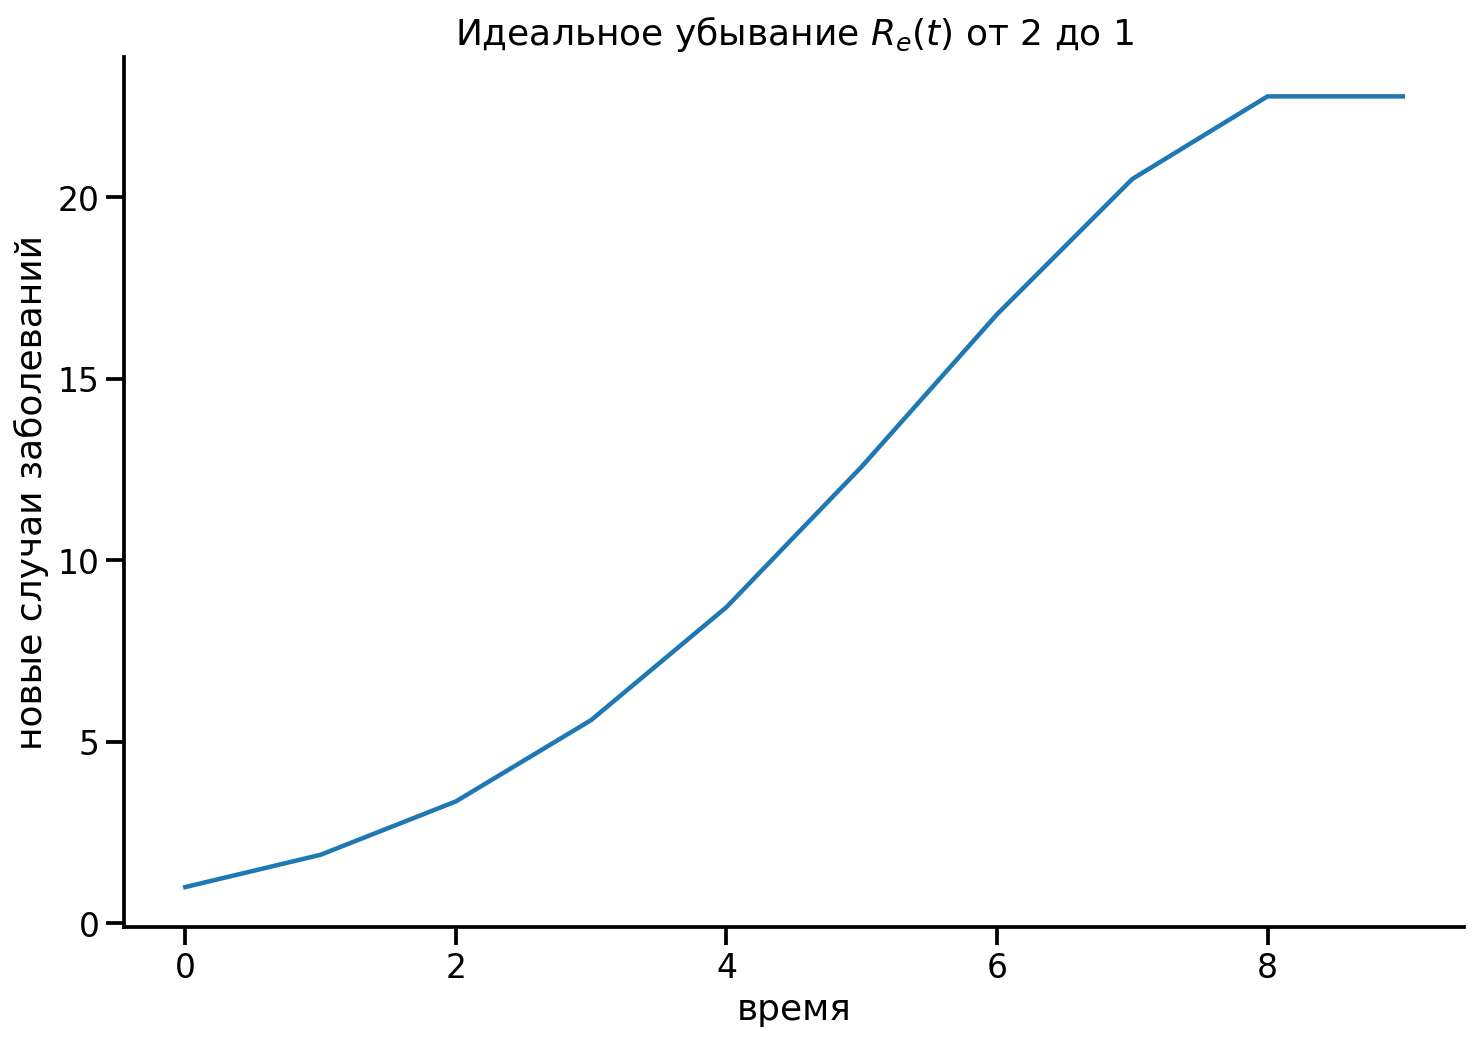

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, y)
ax.set(
    xlabel="время",
    ylabel="новые случаи заболеваний",
    title="Идеальное убывание $R_e(t)$ от 2 до 1",
)
sns.despine();

Вы можете видеть, что в последний день, когда $R_e(t)$ равен 1, мы получаем то же количество новых заражений, что и в предыдущий день, потому что каждый зараженный заражает всего одного человека.

Неявное предположение в генеративном процессе выше заключается в том, что зараженный человек заразен только один день, и что затем ему требуется всего один день, чтобы заразить других людей.

### Построение модели

Какой тип априорной вероятности будет установлен для этого изменяющегося во времени фактора воспроизводства $R_e(t)$? Априорная информация, которая у нас есть, заключается в том, что она не будет резко меняться от одного дня к другому. Мы кодируем эту информацию с помощью *априорной вероятности случайного блуждания*:

$$ R_e(t) \sim \mathcal{N}(R_e(t-1), \sigma) $$

где $\sigma$ контролирует ширину шага случайного блуждания. К счастью, это распределение уже включено в PyMC3. Поскольку мы знаем, что фактор воспроизводства может быть только положительным, мы берем `exp` неограниченного случайного блуждания (которое тогда будет в логарифмическом пространстве), чтобы сделать его положительным.

Таким образом, модель становится:

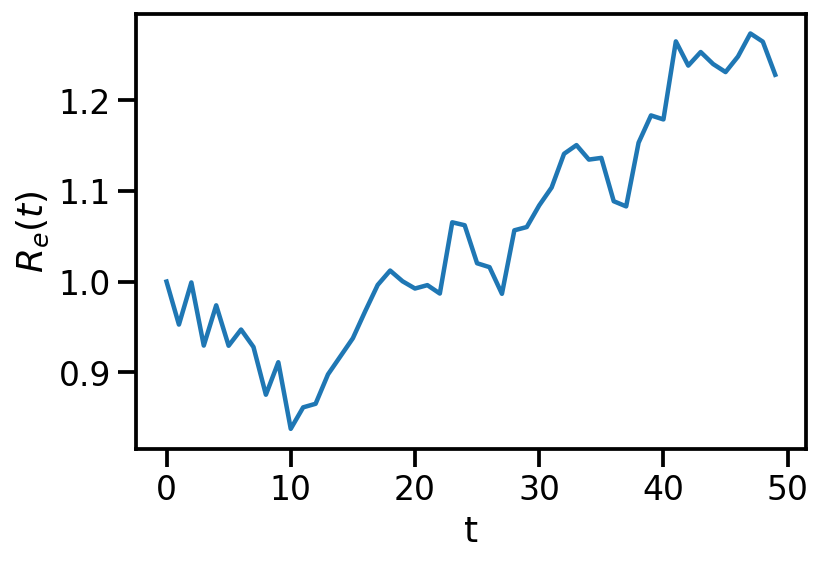

In [23]:
# Генеративный процесс в логарифмическом пространстве
N = 50
r_log = np.zeros(N)
# Среднеквадратичное отклонение
sigma = 0.035
for i in range(1, N):
    r_log[i] = stats.norm(r_log[i - 1], sigma).rvs()
r = np.exp(r_log)
plt.plot(r)
plt.ylabel("$R_e(t)$")
plt.xlabel("t");

In [28]:
# Создаем модель с использованием PyMC для моделирования динамически изменяющегося репродуктивного числа Rt
with pm.Model() as model_r_t:
    # Определяем логарифм динамически изменяющегося Rt, используя гауссово случайное блуждание
    # Оно моделирует постепенные изменения Rt во времени
    # Параметр sigma=0.035 задает вариативность Rt в каждом временном шаге
    log_r_t = pm.GaussianRandomWalk("log_r_t", sigma=0.035, shape=len_observed)
    
    # Применяем экспоненциальную функцию для получения Rt из логарифма Rt,
    # чтобы получить Rt исключительно положительным
    r_t = pm.Deterministic("r_t", pm.math.exp(log_r_t))

    # Инициализируем начальную популяцию зараженных
    # Используем экспоненциальное распределение с параметром 0.01
    seed = pm.Exponential("seed", 0.01)
    
    # Создаем начальный массив y0, в который будем сохранять динамику инфекций
    # Инициализируем его нулями на всю длину наблюдений
    y0 = tt.zeros(len_observed)
    
    # Устанавливаем первый элемент y0 как начальную популяцию зараженных
    y0 = tt.set_subtensor(y0[0], seed)

    # Реализуем рекурсивный алгоритм для вычисления прогрессии инфекций во времени
    # Каждый последующий элемент инфекции y[t] будет равен значению предыдущей инфекции, умноженному на r_t
    outputs, _ = theano.scan(
        fn=lambda t, y, r_t: tt.set_subtensor(y[t], r_t[t -1] * y[t - 1]),  # функция обновления инфекций
        sequences=[tt.arange(1, len_observed)],  # перебор временных точек, начиная с 1
        outputs_info=y0,  # начальное состояние инфекций
        non_sequences=r_t,  # передаем r_t как параметр, изменяющийся во времени
        n_steps=len_observed - 1  # количество шагов для охвата всех наблюдений
    )

    # Определяем детерминированную переменную infections, которая хранит предсказанное значение инфекций на последнем шаге
    infections = pm.Deterministic("infections", outputs[-1])

    # Ограничиваем предсказанное количество инфекций в диапазоне от 0 до 10 000 000
    infections = tt.clip(infections, 0, 10_000_000)

    # Определяем функцию правдоподобия (Likelihood) для оценки параметров модели
    # Используем отрицательное биномиальное распределение, чтобы моделировать наблюдаемые данные
    # Alpha является случайной величиной из гамма-распределения со средним значением 6 и стандартным отклонением 1
    pm.NegativeBinomial(
        "obs", infections, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=new_cases
    )

(0.0, 100000.0)

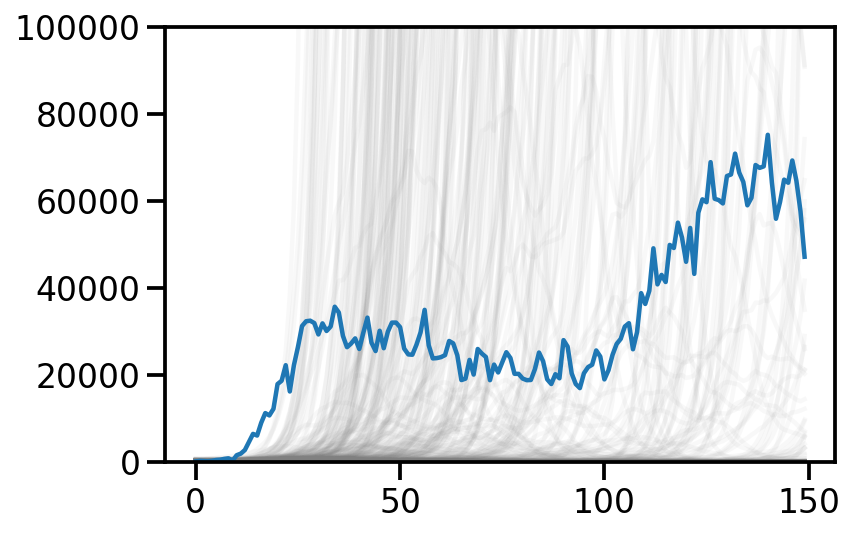

In [29]:
with model_r_t:
    prior_pred = pm.sample_prior_predictive()

plt.plot(prior_pred["infections"].T, color="0.5", alpha=0.05)
plt.plot(new_cases.values)
plt.ylim(0, 100_000)

In [31]:
with model_r_t:
    _kwargs = sampler_kwargs()
    trace = pm.sample(**_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 305 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


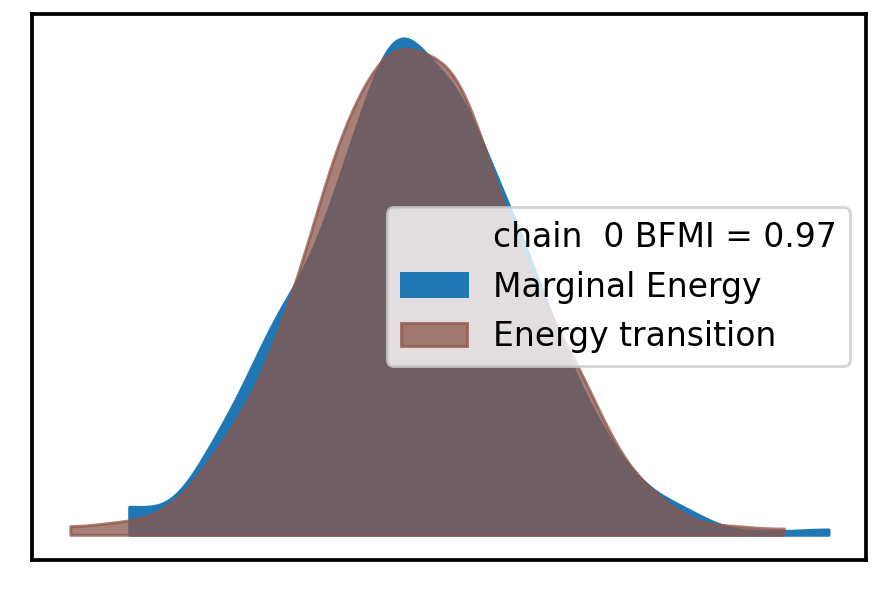

In [32]:
az.plot_energy(trace);

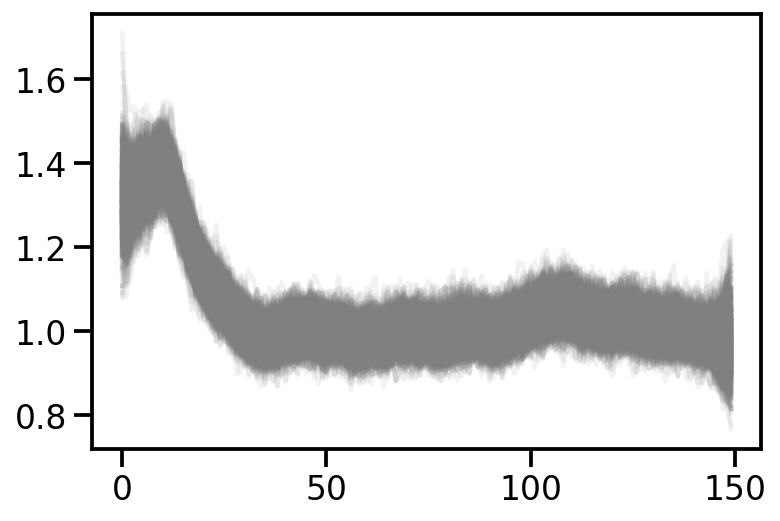

In [33]:
post_rt = trace.posterior["r_t"].sel(chain=0).to_dataframe()["r_t"].unstack().T

plt.plot(post_rt, color="0.5", alpha=0.1);

C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\pymc3\sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


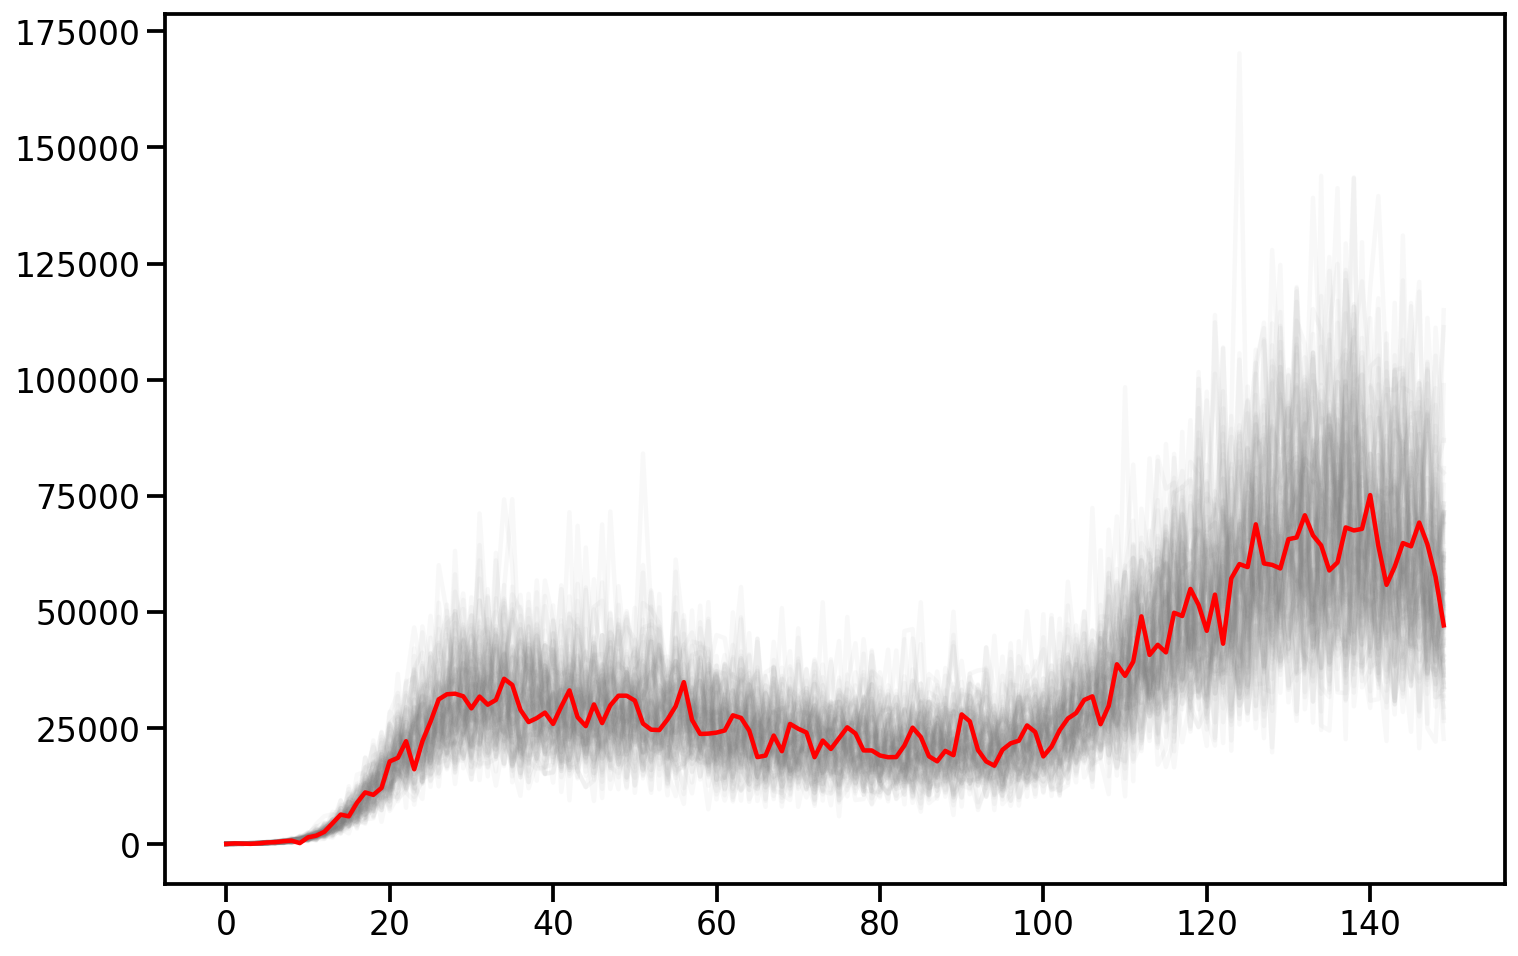

In [34]:
with model_r_t:
    post_pred_r_t = pm.sample_posterior_predictive(trace.posterior, samples=100)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_pred_r_t["obs"].T, color="0.5", alpha=0.05)
ax.plot(new_cases.values, color="r");

## Учет задержки заражения

В действительности время, необходимое первичному человеку для заражения других, следует распределению. Они могут заразить одного человека на следующий день, двух — через день и т. д. Это распределение задержки официально известно как «*время генерации*», и мы смоделируем его с помощью распределения вероятностей из [этого исследования](https://www.ijidonline.com/article/S1201-9712(20)30119-3/pdf) (исследование на самом деле дает оценку чего-то, тесно связанного со временем генерации, но ее можно использовать для этого).

В статье приведена простая формулировка того, как вывести распределение времени генерации для COVID-19:

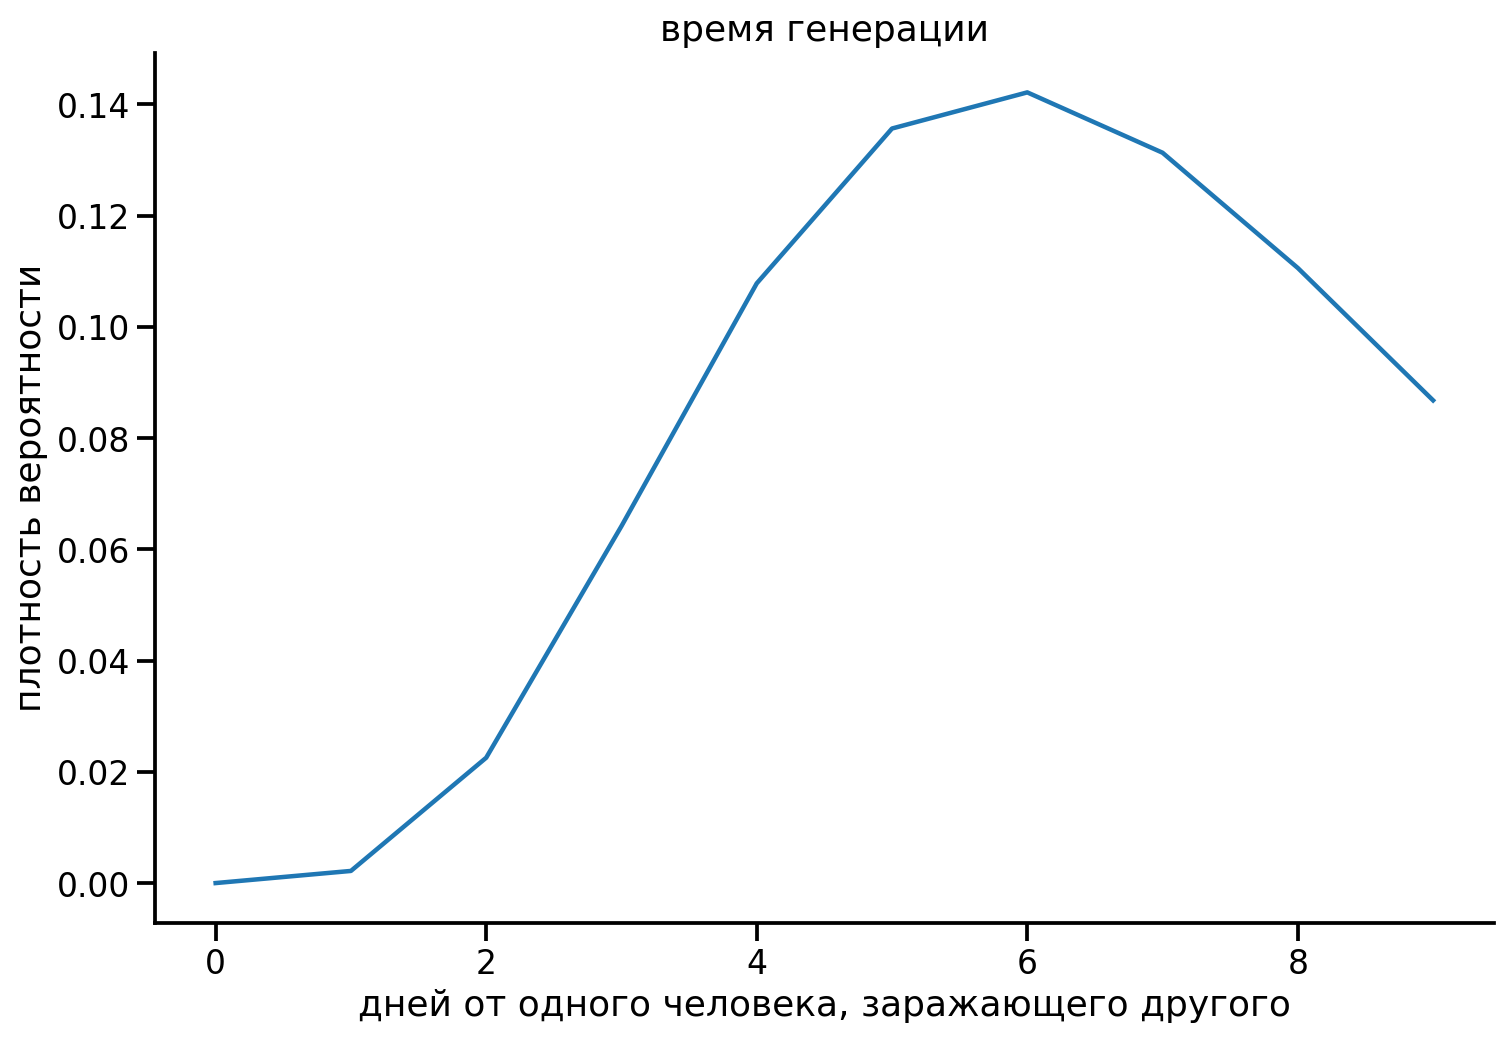

In [35]:
# Задаем параметры гамма-распределения
shape = 5.48
rate = 0.77

# Создаем гамма-распределение
# scale = 1 / rate, поскольку в scipy rate = 1/scale
generation_time = stats.gamma(a=shape, scale=1/rate)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, generation_time.pdf(ts))
ax.set(
    xlabel="дней от одного человека, заражающего другого",
    ylabel="плотность вероятности",
    title="время генерации",
)
sns.despine();

Чтобы включить этот эффект в нашу генеративную модель, нам нужно сделать свертку. Интуитивно понятно, что вместо новых случаев в день $t$, зависящих только от новых случаев в день $t-1$, теперь они зависят от новых случаев в (потенциально) все предыдущие дни, поскольку между моментом заражения человека и заражением другого человека могло пройти 5 дней. Нам нужно учесть всех этих ранее инфицированных людей и то, с какой вероятностью они заражают людей сегодня. Мы достигаем этого, взвешивая количество новых инфицированных людей $i$ дней назад -- $y_{t-i}$ -- по времени генерации $g_i$ для этой конкретной задержки, а также по эффективному числу воспроизводства в этот день $R_e(t-i)$:

$$ y_t = \sum_{i=1}^{M}y_{t-i} R_e(t-i) g_i $$

Более подробную информацию об этом генеративном процессе см. в этой публикации: https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html.

Обновив нашу модель генеративного процесса соответствующим образом, мы получаем:

In [36]:
# Задаем количество дней
n_days = 30
# Задаем массив времени
ts = np.arange(0, n_days)
# Определяем репродуктивное число, убывающее со временем
Rt = np.linspace(2, 1, n_days)
# Инициализируем массив числа заражений
y = np.zeros(n_days)
y[0] = 1
# Считаем по формуле число заболевших
for t in ts[1:]:
    # Иттерируемся по каждому дню
    for i in range(1, t + 1):
        y[t] += y[t - i] * Rt[t - i] * generation_time.pdf(i)

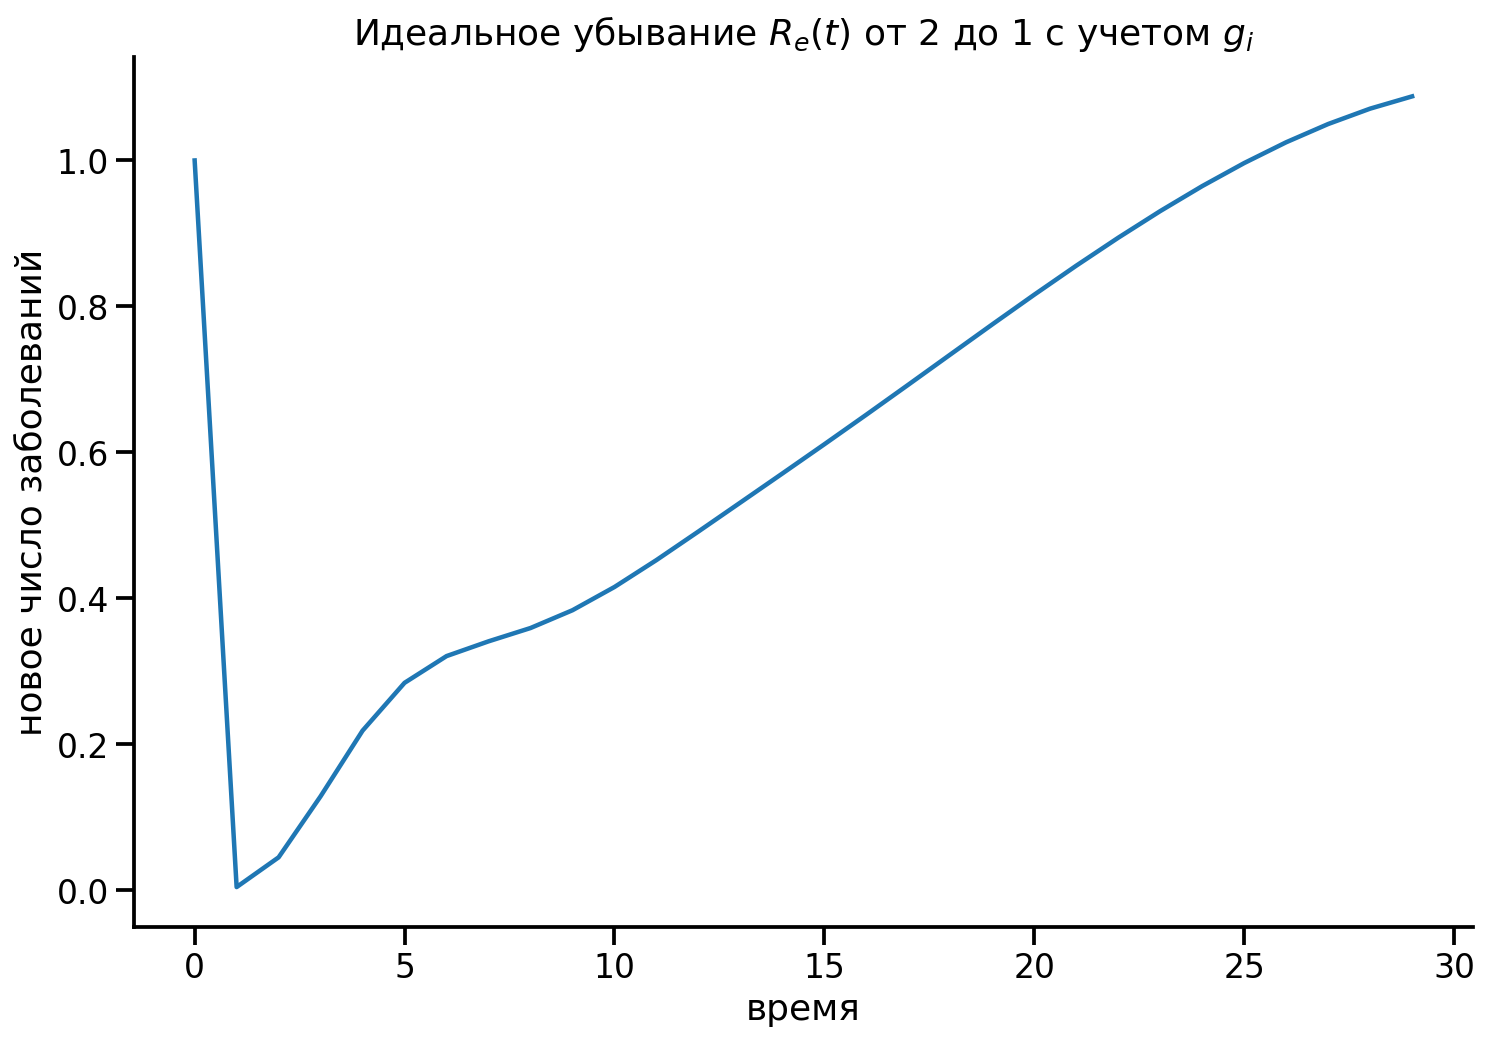

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, y)
ax.set(
    xlabel="время",
    ylabel="новое число заболеваний",
    title="Идеальное убывание $R_e(t)$ от 2 до 1 с учетом $g_i$",
)
sns.despine();

Как видите, учет задержки между передачей болезни от одного человека другому значительно замедляет распространение. Чем больше *время генерации*, тем медленнее распространение.

К сожалению, здесь все становится немного техничным, не беспокойтесь слишком сильно об индивидуальном коде, но поверьте, что мы включаем время генерации сейчас в нашу рекурсивную функцию `scan`.

In [38]:
# Фуннкция для генерации временных интервалов
def _get_generation_time_interval():
    """Создает дискретные P(Генерационный интервал)
    Source: https://www.ijidonline.com/article/S1201-9712(20)30119-3/pdf"""
    import scipy.stats as sps

    # Задаем параметры гамма-распределения
    shape = 2.6
    rate = 0.4

    # Создаем гамма-распределение
    # scale = 1 / rate, поскольку в scipy rate = 1/scale
    dist = sps.gamma(a=shape, scale=1/rate)

    # Дискретные генерационные интервалы максимально 20 дней (как будто скользящее окно размером 20)
    g_range = np.arange(0, 20)
    gt = pd.Series(dist.cdf(g_range), index=g_range)
    gt = gt.diff().fillna(0)
    gt /= gt.sum()
    gt = gt.values
    return gt


# Функция для получения матрицы из массивов генерационных интервалов
def _get_convolution_ready_gt(len_observed):
    """Ускоряет theano.scan, предварительно вычисляя вектор интервала времени генерации. Спасибо Junpeng Lao за эту оптимизацию.
    Пожалуйста, ознакомьтесь с математикой моделирования вспышки здесь:
    https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html"""
    gt = _get_generation_time_interval()
    convolution_ready_gt = np.zeros((len_observed - 1, len_observed))
    for t in range(1, len_observed):
        begin = np.maximum(0, t - len(gt) + 1)
        slice_update = gt[1 : t - begin + 1][::-1]
        convolution_ready_gt[t - 1, begin : begin + len(slice_update)] = slice_update
    convolution_ready_gt = theano.shared(convolution_ready_gt)
    return convolution_ready_gt

In [40]:
# Генерируем данные для свертки на основе времени задержки заражения
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

# Определяем модель PyMC для оценки динамики Rt с учетом времени задержки заражения
with pm.Model() as model_r_t_infection_delay:
    
    # Задаем логарифм динамически изменяющегося Rt как гауссовское случайное блуждание (GaussianRandomWalk)
    # с дисперсией sigma=0.035 и длиной len_observed. GaussianRandomWalk позволяет
    # Rt меняться плавно и моделирует его как последовательность значений, где каждое
    # значение зависит от предыдущего.
    log_r_t = pm.GaussianRandomWalk(
        "log_r_t",               # Имя переменной в модели
        sigma=0.035,             # Дисперсия случайного блуждания, контролирует изменчивость Rt
        shape=len_observed       # Длина последовательности, равная длине наблюдений
        # dims=["date"]          # Опциональный параметр, позволяющий указать ось времени
    )
    
    # Вычисляем Rt путем экспоненцирования log_r_t, чтобы Rt всегда было положительным
    # и соответствовало реальному числу репродукции.
    r_t = pm.Deterministic("r_t", pm.math.exp(log_r_t))  # , dims=["date"])

    # Инициализируем начальную популяцию зараженных людей с использованием экспоненциального распределения
    # с параметром 0.01, чтобы смоделировать начальное число зараженных.
    seed = pm.Exponential("seed", 0.01)
    
    # Создаем начальный массив для хранения числа зараженных на каждом временном шаге
    # На всех шагах, кроме первого, начальные значения установлены в нуль.
    y0 = tt.zeros(len_observed)
    
    # Задаем начальное число зараженных на первом временном шаге как начальное значение seed.
    y0 = tt.set_subtensor(y0[0], seed)

    # Используем функцию `theano.scan` для рекурсивного вычисления количества заражений во времени.
    # Это позволяет моделировать динамику инфекции с учетом Rt и распределения времени задержки.
    # На каждом временном шаге t, число новых заражений рассчитывается как взвешенная сумма всех
    # предыдущих значений (с учетом коэффициентов из свертки), умноженных на Rt.
    outputs, _ = theano.scan(
        fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t * y * gt)),  
        sequences=[tt.arange(1, len_observed), convolution_ready_gt],  
        outputs_info=y0,          
        non_sequences=r_t,        
        n_steps=len_observed - 1  
    )

    # Определяем `infections` как детерминированную переменную, которая хранит предсказанное
    # значение инфекций на последнем шаге.
    infections = pm.Deterministic("infections", outputs[-1])

    # Определяем функцию правдоподобия (Likelihood) для оценивания параметров модели на основе
    # наблюдаемых данных.
    # Используем отрицательное биномиальное распределение для моделирования числа случаев заражения
    # (с учетом их дисперсии), параметризуя его `infections` и случайной величиной alpha.
    # Alpha берется из гамма-распределения со средним 6 и стандартным отклонением 1.
    pm.NegativeBinomial(
        "obs", infections,                       # Число инфекций как среднее отрицательного биномиала
        alpha=pm.Gamma("alpha", mu=6, sigma=1),  # Alpha из гамма-распределения
        observed=new_cases                       # Наблюдаемые данные - фактические случаи заражения
    )


In [41]:
with model_r_t_infection_delay:
    _kwargs = sampler_kwargs()
    trace_r_t_infection_delay = pm.sample(**_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 306 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


<AxesSubplot:>

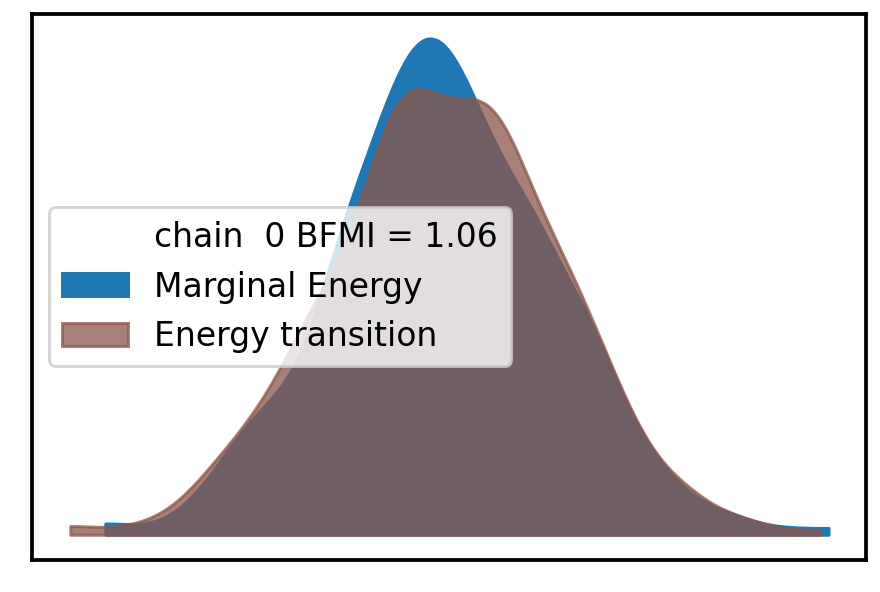

In [42]:
az.plot_energy(trace_r_t_infection_delay)

[Text(0.5, 0, 'Days'), Text(0, 0.5, '$R_e(t)$')]

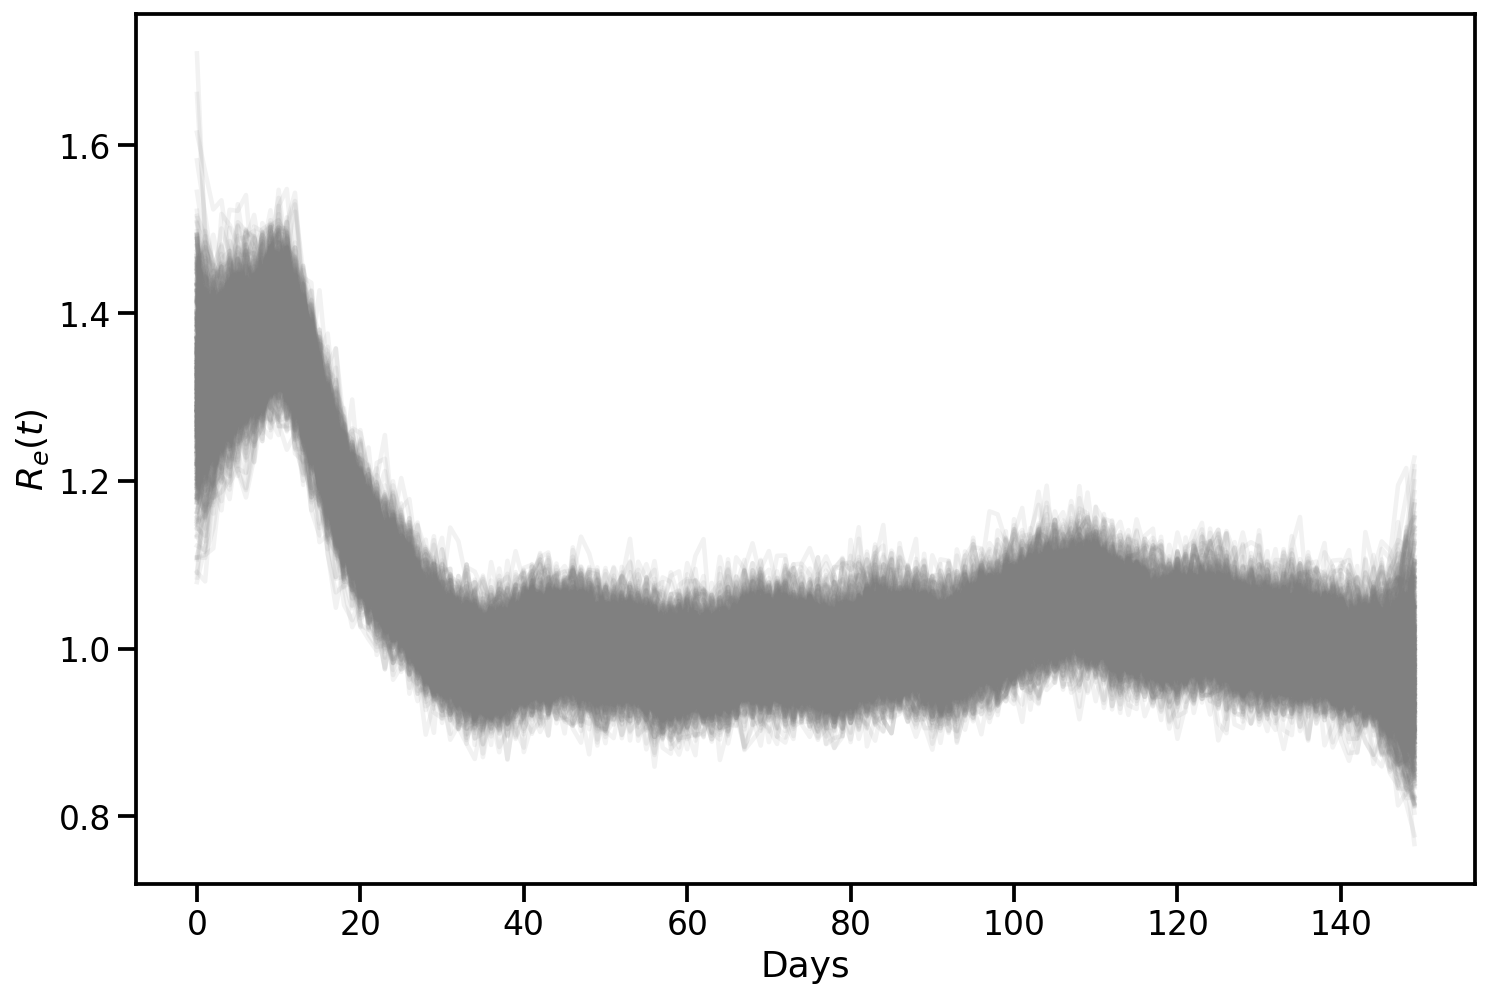

In [52]:
post_r_t_infection_delay = trace_r_t_infection_delay.posterior["r_t"].sel(chain=0).to_dataframe()["r_t"].unstack().T
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_rt, color="0.5", alpha=0.1);
ax.set(xlabel="Days", ylabel="$R_e(t)$")

#### Апостериорный прогноз

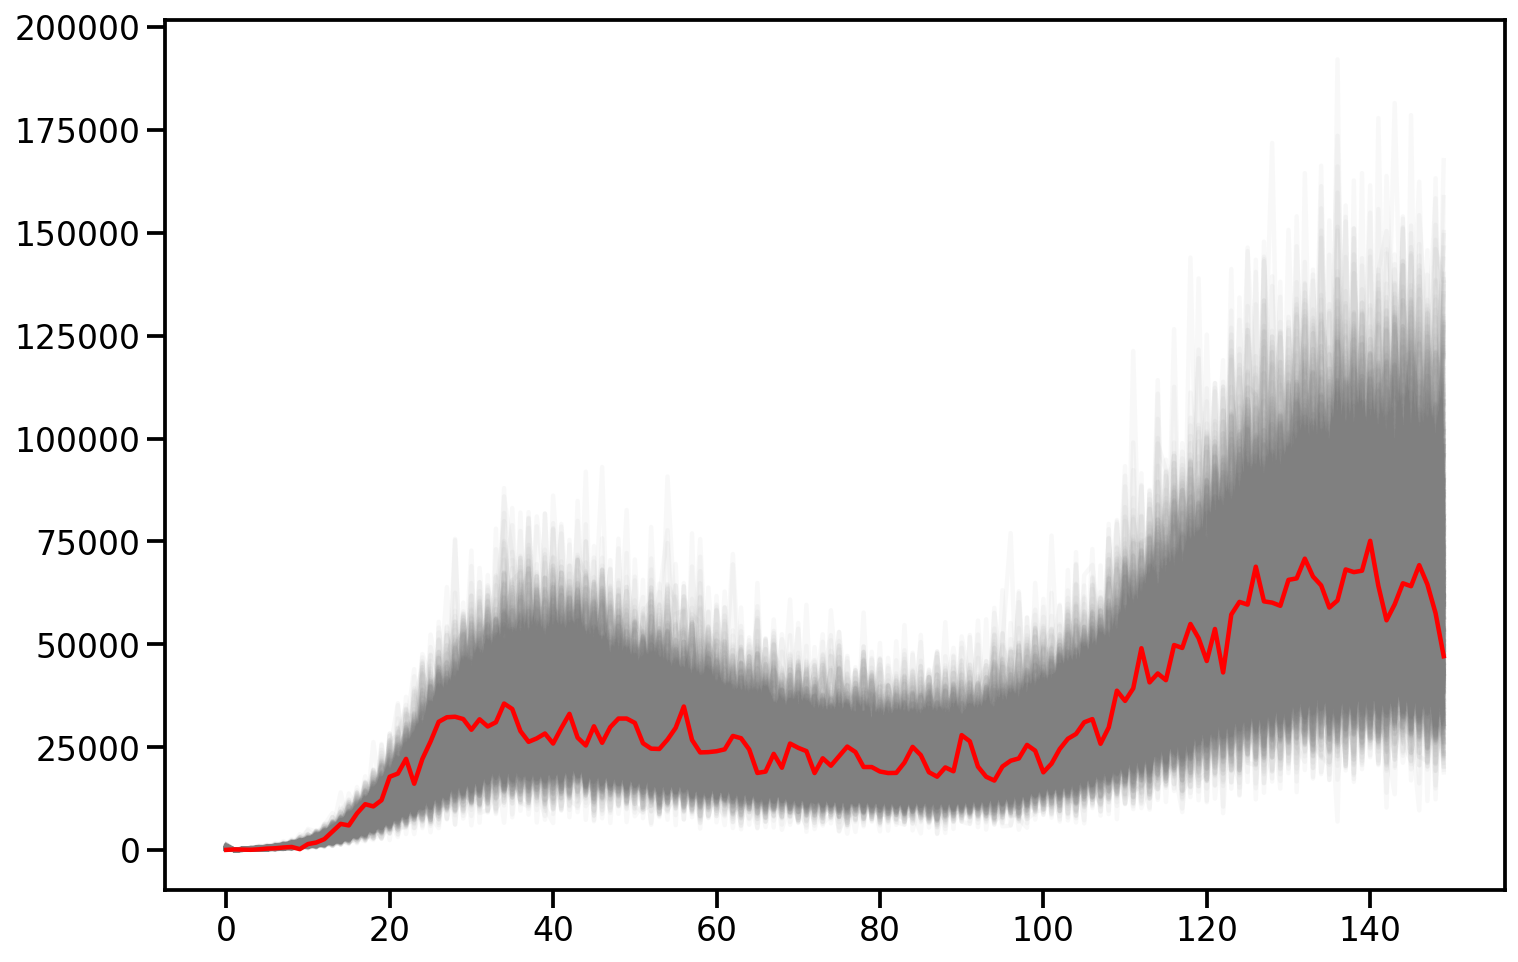

In [48]:
with model_r_t_infection_delay:
    post_pred_r_t_infection_delay = pm.sample_posterior_predictive(
        trace_r_t_infection_delay
    )

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_pred_r_t_infection_delay["obs"].T, color="0.5", alpha=0.05)
ax.plot(new_cases.values, color="r");

In [53]:
az.compare({"r_t": trace, "r_t_infection_delay": trace_r_t_infection_delay})

C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\arviz\stats\stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\arviz\stats\stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\arviz\stats\stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You

rank          loo      p_loo      d_loo        weight  \
r_t                     0 -1477.237899   9.324024   0.000000  1.000000e+00   
r_t_infection_delay     1 -1527.170445  13.893277  49.932546  7.918999e-12   

                            se        dse  warning loo_scale  
r_t                  15.167757   0.000000     True       log  
r_t_infection_delay  18.424457  18.228357     True       log

## Получение числа инфицированных

Пока что у нас есть генеративная модель того, как люди передают болезнь от одного человека к другому. Однако у нас нет данных о том, когда люди передали болезнь, у нас есть данные о том, кто получил положительный результат теста. Поэтому нам нужно еще больше отсрочить эту функцию, когда инфицированный пациент фактически появится в качестве положительного теста в наших данных.

Для этого мы будем использовать распределение задержки между заражением и подтвержденным положительным тестом, также известное как *распределение задержки начала*. Чтобы оценить это распределение, мы можем использовать данные из [Рабочей группы по открытым данным COVID-19](https://github.com/beoutbreakprepared/nCoV2019), которая спрашивала пациентов с COVID-19, как давно у них начались симптомы ([Xu et al., 2020](https://www.nature.com/articles/s41597-020-0448-0)). Однако начало симптомов не то же самое, что и при заражении, потому что есть инкубационный период, в течение которого вирус распространяется в организме, пока симптомы не заметны. Чтобы исправить это, мы просто добавляем инкубационный период к началу *распределения задержки начала* ([rt.live](https://rt.live) предполагает 5 дней). Вы можете увидеть это смещение в плоской области с 1 по 5 день на следующем графике.

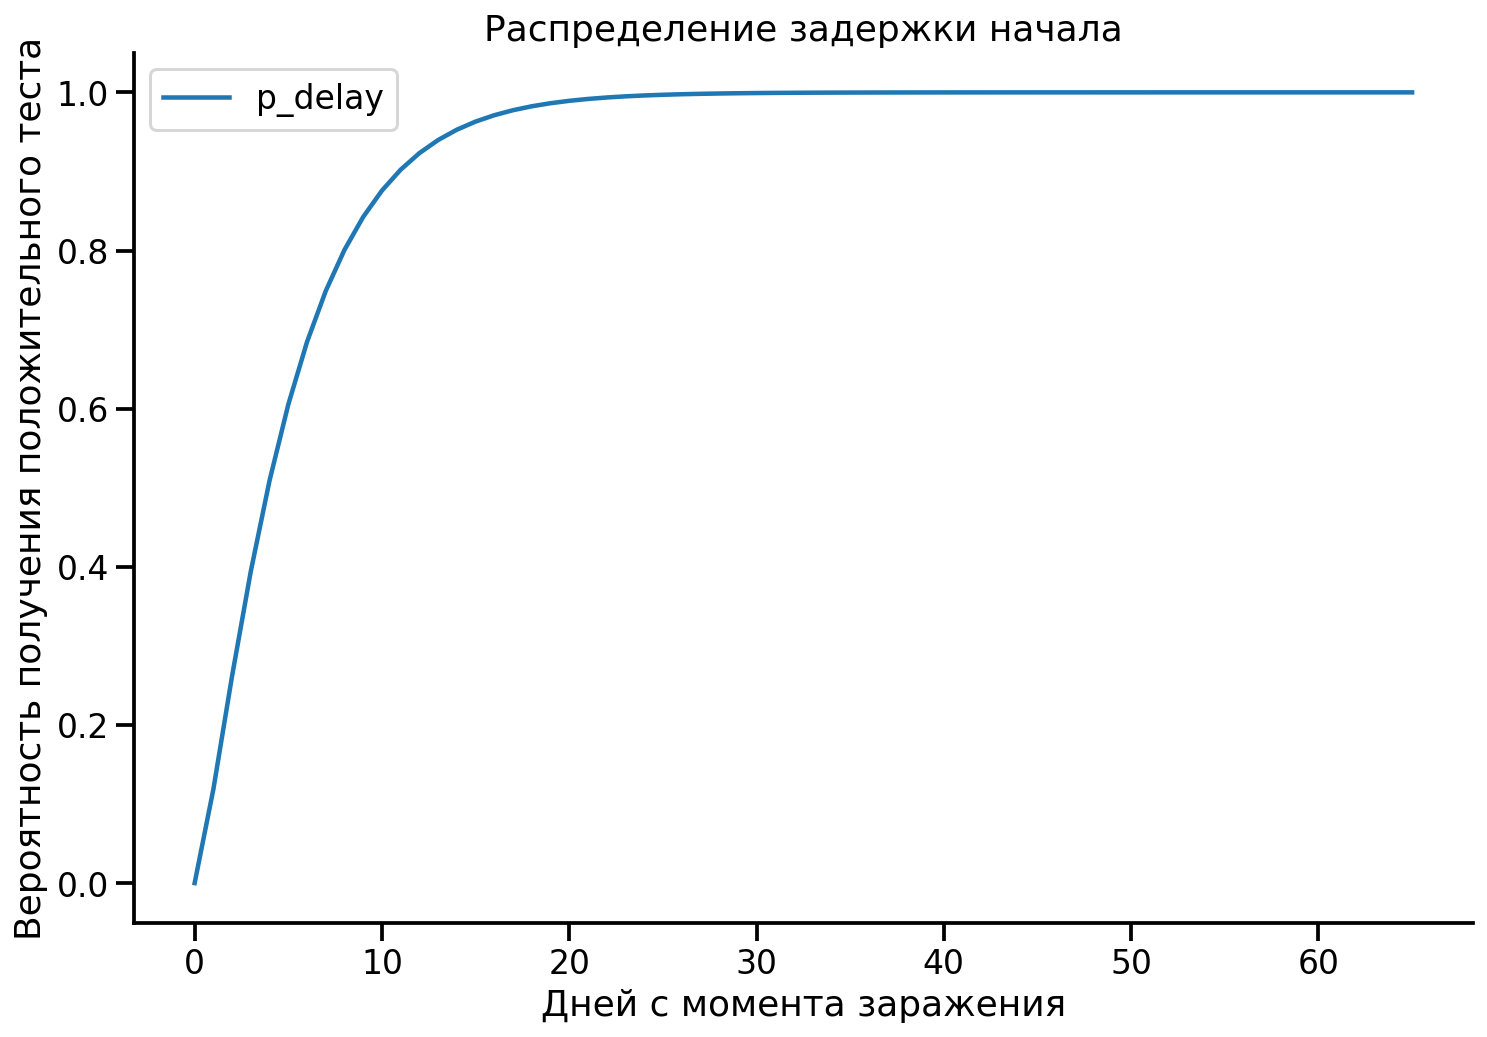

In [82]:
import scipy.stats as sps

# Задаем параметры гамма-распределения
shape = 1.352
rate = 0.265

# Создаем гамма-распределение
# scale = 1 / rate, поскольку в scipy rate = 1/scale
dist = sps.gamma(a=shape, scale=1/rate)

# Дискретные генерационные интервалы максимально 20 дней (как будто скользящее окно размером 20)
inc_range = np.arange(0, 66)
inc = pd.Series(dist.cdf(inc_range), index=inc_range)

p_delay = pd.read_csv('./data/p_delay.csv')
p_delay.iloc[:66] = inc.values.reshape(-1, 1)
ax = p_delay.plot(figsize=(12, 8))
ax.set(
    title="Распределение задержки начала",
    ylabel="Вероятность получения положительного теста",
    xlabel="Дней с момента заражения",
)
sns.despine();

Теперь нам нужно лишь свернуть полученную выше функцию количества людей, заразившихся каждый день, с распределением задержки начала заболевания, чтобы получить количество людей, которые обнаружат положительный результат теста в этот день.

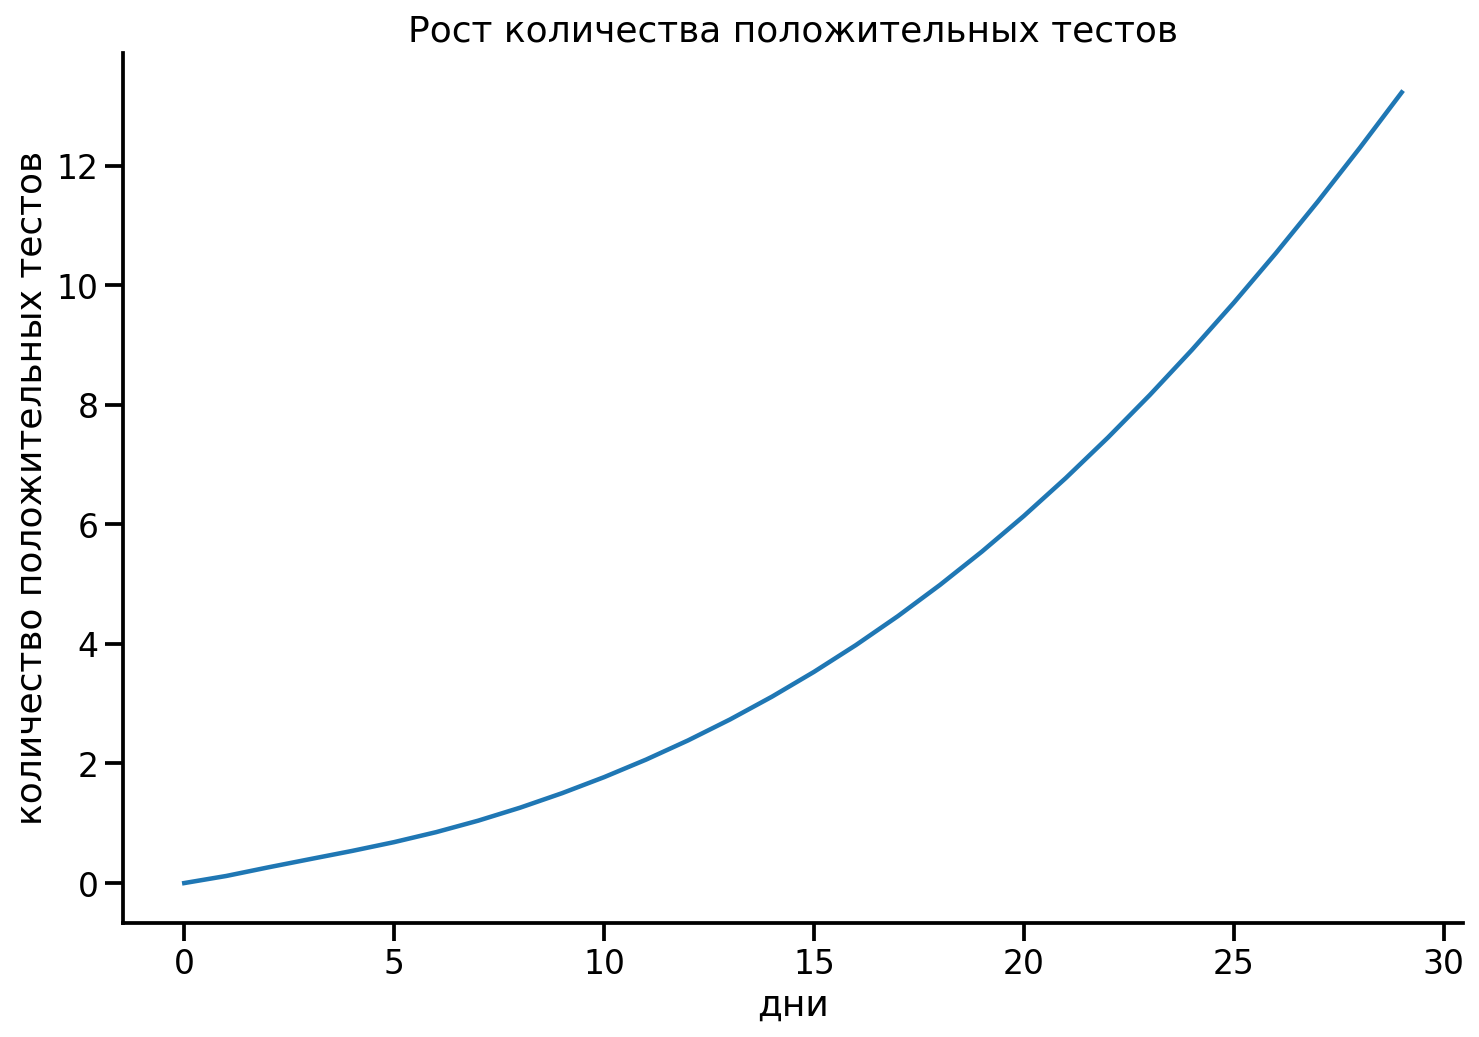

In [83]:
_p_delay = p_delay.values.flatten()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, np.convolve(y, _p_delay)[:n_days])
ax.set(
    xlabel="дни",
    ylabel="количество положительных тестов",
    title="Рост количества положительных тестов",
)
sns.despine();

In [85]:
def conv(a, b, len_observed):
    """Perform a 1D convolution of a and b"""
    from theano.tensor.signal.conv import conv2d

    return conv2d(
        tt.reshape(infections, (1, len_observed)),
        tt.reshape(_p_delay, (1, len(_p_delay))),
        border_mode="full",
    )[0, :len_observed]

In [87]:
# Создаем вероятностную модель с использованием PyMC
with pm.Model() as model_r_t_onset:
    
    # Определение динамически изменяющегося логарифма R_t с использованием случайного блуждания
    log_r_t = pm.GaussianRandomWalk(
        "log_r_t",      # Название параметра для отслеживания
        sigma=0.035,    # Стандартное отклонение для случайного блуждания, определяющее плавность изменений
        shape=len_observed,  # Количество временных шагов (дней) для моделирования
    )
    
    # Преобразование log(R_t) в R_t, чтобы получить положительные значения
    r_t = pm.Deterministic("r_t", pm.math.exp(log_r_t))  # Определение R_t как экспоненты от log(R_t)

    # Инициализация начальной популяции зараженных
    seed = pm.Exponential("seed", 0.01)  # Начальная популяция инфекций с экспоненциальным распределением
    y0 = tt.zeros(len_observed)  # Массив для хранения количества инфекций на каждом временном шаге
    y0 = tt.set_subtensor(y0[0], seed)  # Установка начального значения зараженных на первый день
    
    # Реализация рекурсивного алгоритма для моделирования инфекций с учетом генерационного интервала
    outputs, _ = theano.scan(
        fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t * y * gt)),
        sequences=[tt.arange(1, len_observed), convolution_ready_gt],
        outputs_info=y0,  # начальное состояние y0 (число инфицированных на каждом шаге)
        non_sequences=r_t,  # параметр R_t, изменяющийся во времени
        n_steps=len_observed - 1,  # количество временных шагов, охватывающих все дни наблюдений
    )
    
    # Определяем infections как детерминированную переменную, представляющую количество инфекций
    infections = pm.Deterministic("infections", outputs[-1])  # Конечный результат обновления для infections
    
    # Ограничиваем предсказанное количество инфекций в диапазоне от 0 до 10 000 000
    infections = tt.clip(infections, 0, 10_000_000)

    # Корректировка прогнозов инфицированных с учетом вероятности положительного теста
    test_adjusted_positive = pm.Deterministic(
        "test_adjusted_positive", conv(infections, _p_delay, len_observed)
    )
    # Используем свертку с `p_delay`, чтобы учесть вероятность задержки до положительного теста

    # Определение функции правдоподобия наблюдаемых данных с использованием отрицательного биномиального распределения
    pm.NegativeBinomial(
        "obs",  # Название вероятностного распределения для наблюдаемых данных
        test_adjusted_positive + 0.1,  # Добавляем небольшой оффсет, чтобы избежать значений 0 на начальных днях
        alpha=pm.Gamma("alpha", mu=6, sigma=1),  # Гиперпараметр alpha с гамма-распределением
        observed=new_cases,  # Передаем реальные данные для обучения модели
    )

    # Вычисляем априорные предсказания, чтобы проанализировать начальные гипотезы и оценки
    prior_pred = pm.sample_prior_predictive()

[(0.0, 100000.0)]

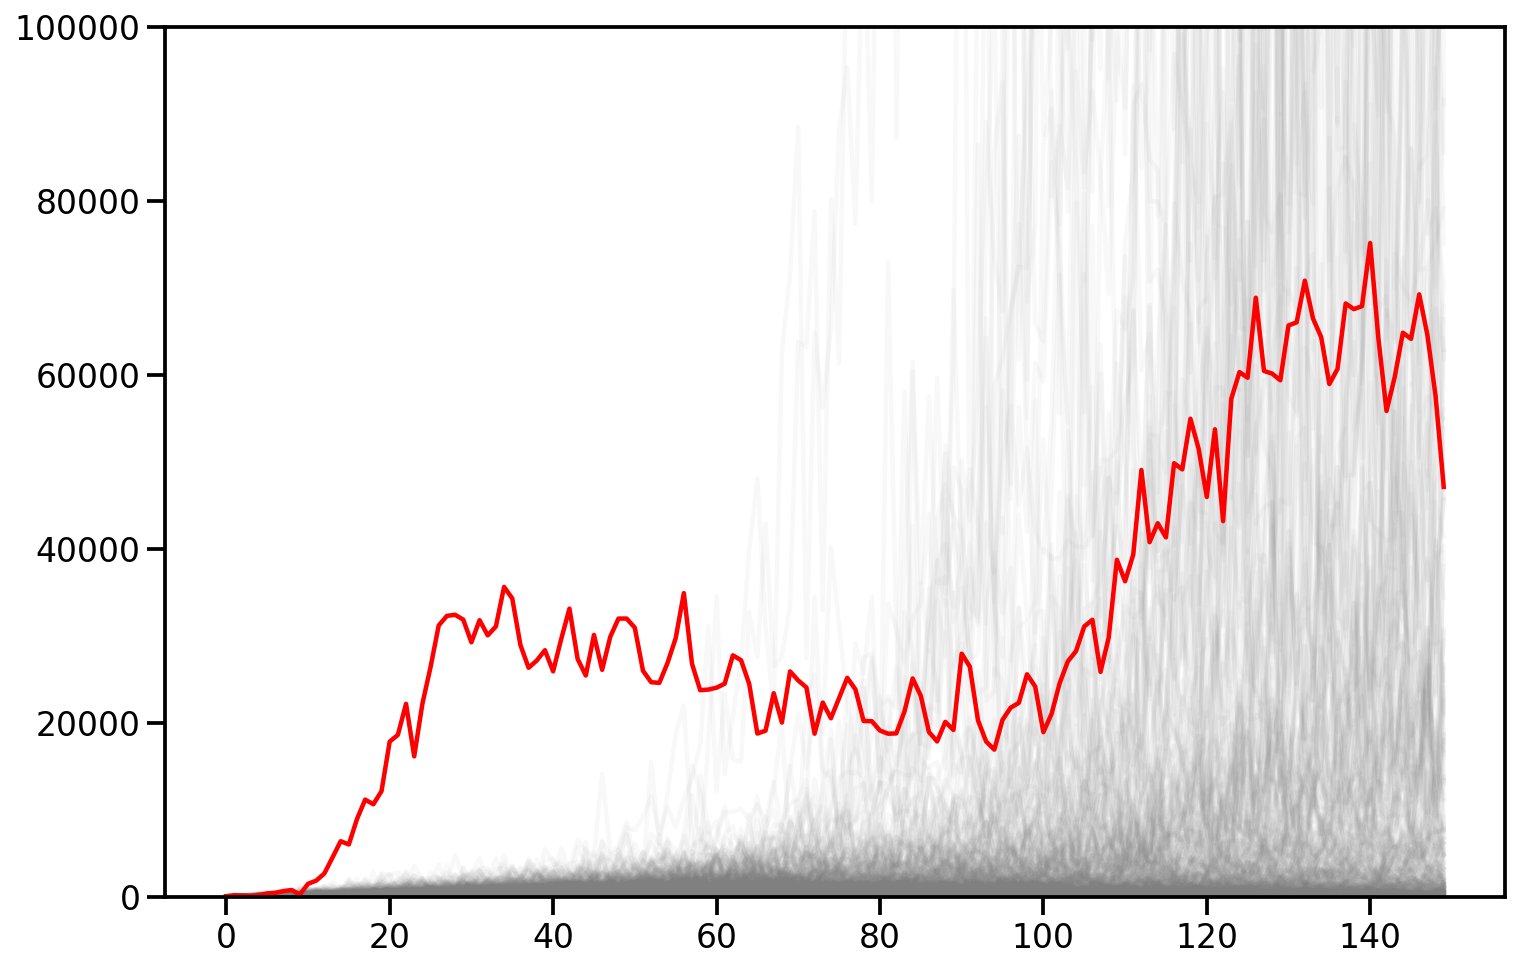

In [88]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred["obs"].T, color="0.5", alpha=0.05)
ax.plot(new_cases.values, color="r")
ax.set(ylim=(0, 100_000))

In [89]:
with model_r_t_onset:
    _kwargs = sampler_kwargs()
    trace_r_t_onset = pm.sample(**_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 537 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


[Text(0.5, 0, 'Days'), Text(0, 0.5, '$R_e(t)$')]

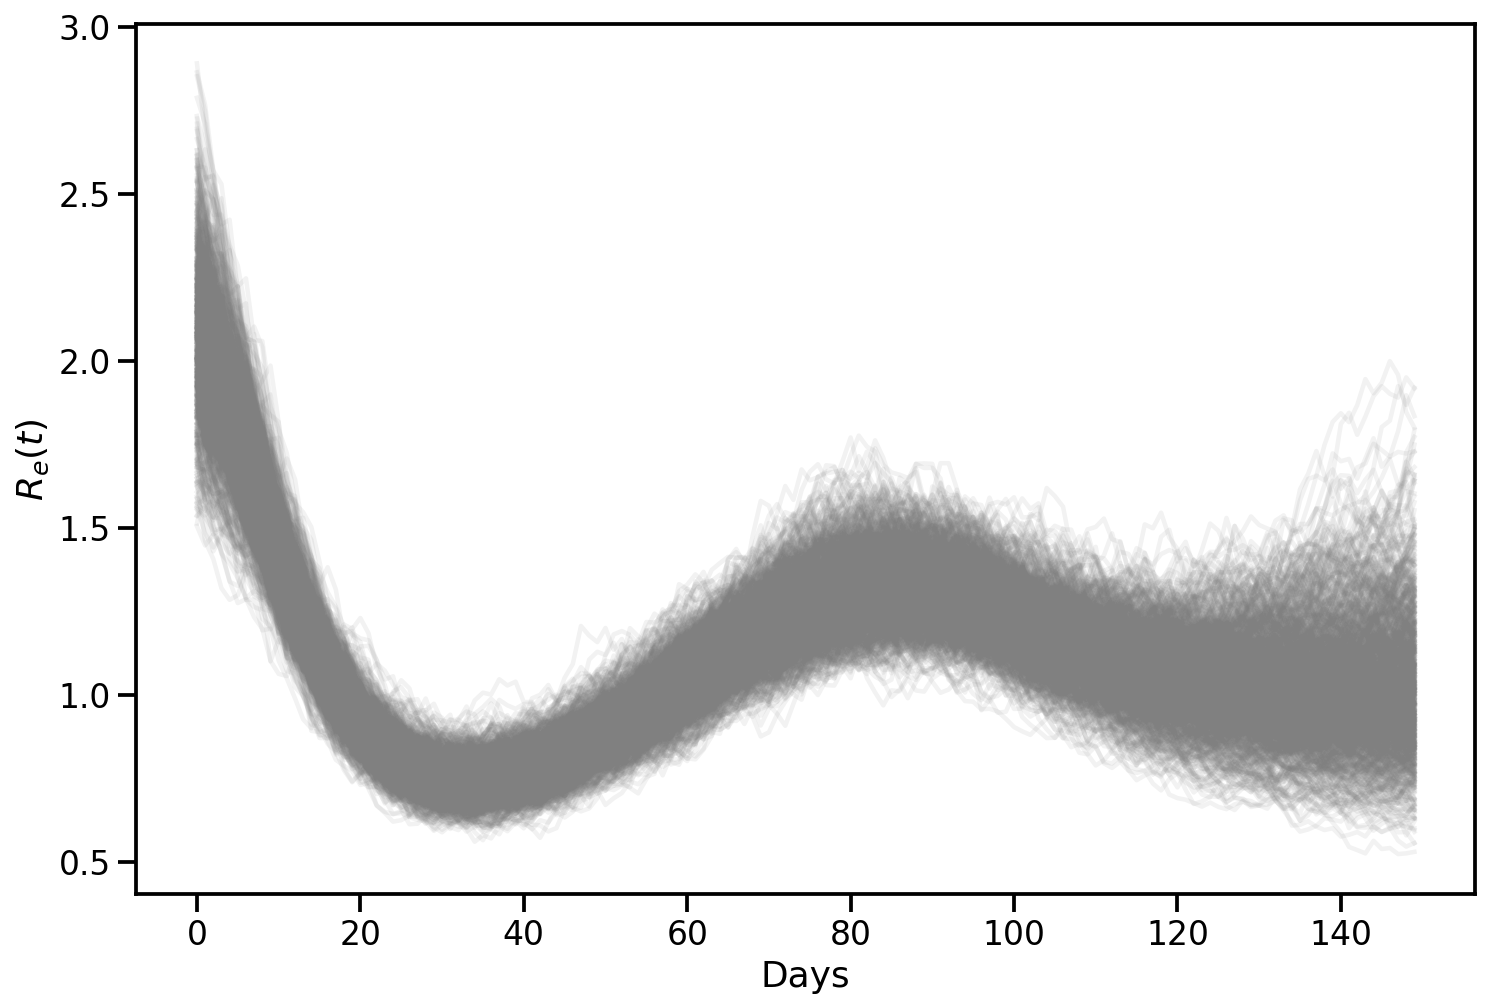

In [91]:
post_r_t_onset = trace_r_t_onset.posterior["r_t"].sel(chain=0).to_dataframe()["r_t"].unstack().T
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_r_t_onset, color="0.5", alpha=0.1);
ax.set(xlabel="Days", ylabel="$R_e(t)$")

[(0.0, 100000.0)]

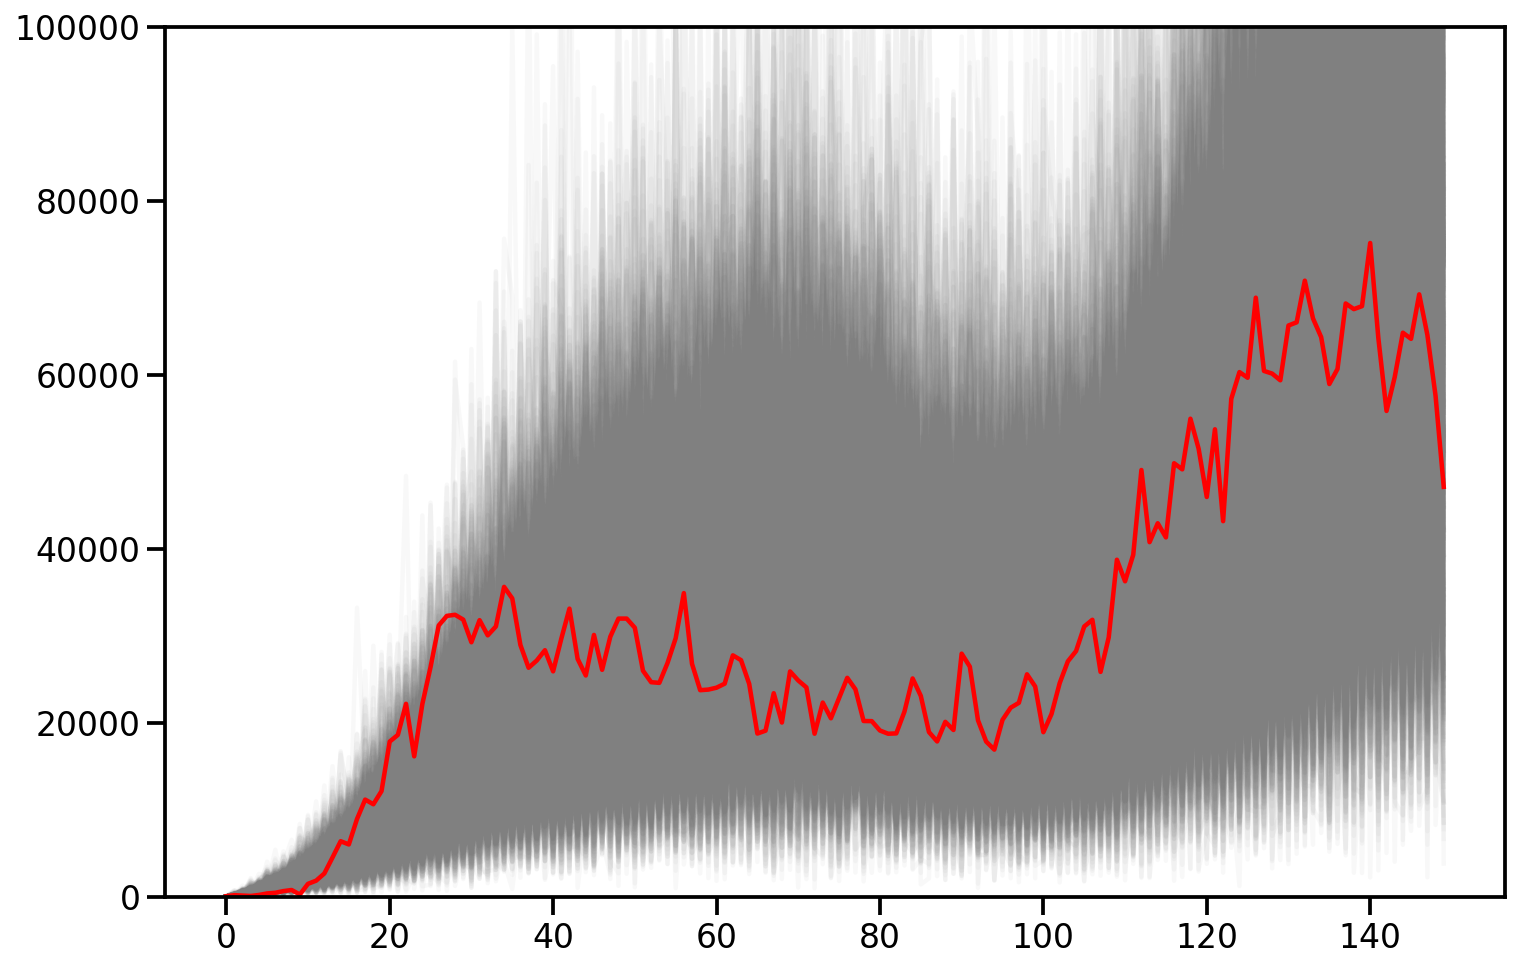

In [92]:
with model_r_t_onset:
    post_pred_r_t_onset = pm.sample_posterior_predictive(trace_r_t_onset)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_pred_r_t_onset["obs"].T, color="0.5", alpha=0.05)
ax.plot(new_cases.values, color="r")
ax.set(ylim=(0, 100_000))

К сожалению, это не совсем сработало. Я не уверен, что не так с моделью, но я оставил это здесь, чтобы продемонстрировать, какие вещи можно делать внутри модели. Исправление модели оставлено в качестве упражнения для мотивированного читателя ;).

In [93]:
az.compare(
    {
        "r_t": trace,
        "infection_delay": trace_r_t_infection_delay,
        "onset": trace_r_t_onset,
    }
)

C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\arviz\stats\stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\arviz\stats\stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
C:\Users\NightMare\anaconda3\envs\covid\lib\site-packages\arviz\stats\stats.py:693: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You

rank          loo      p_loo       d_loo        weight  \
r_t                 0 -1477.237899   9.324024    0.000000  1.000000e+00   
infection_delay     1 -1527.170445  13.893277   49.932546  0.000000e+00   
onset               2 -1773.694332  26.211538  296.456434  4.737142e-10   

                         se         dse  warning loo_scale  
r_t               15.167757    0.000000     True       log  
infection_delay   18.424457   18.228357     True       log  
onset            183.008809  187.996402     True       log

## Корректировка количества проведенных тестов

При рассмотрении количества сырых положительных тестов становится ясно, что на это число будет влиять количество людей, которых вы протестировали: чем больше вы тестируете, тем больше случаев вы обнаружите.

Это важно для моделирования, поскольку существует огромная изменчивость в количестве проводимых тестов с течением времени (наращивание тестов в целом по мере создания большего количества возможностей для тестирования, но также и потому, что по выходным обычно проводится меньше тестов). Это сместит нашу оценку $R_e(t)$, если не учитывать это.

Таким образом, в модели мы умножаем воздействие теста $e_t$ (нормализованную величину, пропорциональную количеству проведенных тестов) на количество положительных тестов из генеративного процесса. Интуитивно, если мы тестируем вдвое больше, мы ожидаем, что положительных тестов будет вдвое больше.

Таким образом, ожидаемое количество положительных тестов $\tilde{z_t}$ будет:

$$ \tilde{z_t} = z_t \cdot e_t $$

где $z_t$ — это выход генеративной модели с примененными задержками.

## Подводя итог генеративному процессу

1. Происходит первичное заражение (это момент времени, к которому мы хотим отнести Rt).

2. *Время генерации* проходит до тех пор, пока не произойдет вторичное заражение.
3. *Время начала* проходит до тех пор, пока у вторично инфицированного человека не появятся симптомы и тесты не станут положительными. Это количество положительных тестов, которое мы ожидали бы, если бы тестирование было постоянным.
4. Умножьте количество положительных тестов (если бы тесты были постоянными) на воздействие тестирования, чтобы получить количество ожидаемых положительных результатов. Это выход модели, который мы используем для подгонки данных.

#### Корректировка прогнозов инфицированных с учетом вероятности положительного теста
    test_adjusted_positive = pm.Deterministic(
        "test_adjusted_positive", conv(infections, _p_delay, len_observed)
    )
    # Определяем случайную величину по распределению Дирихле с alpha=[1,1,1,1,1,1,1]
    w = pm.Dirichlet("w", a=[1, 1, 1, 1, 1, 1, 1])
    
    # Применяем `scan` для итерации по `test_adjusted_positive`
    weighted_output, _ = scan(
        fn=lambda t, test_value: test_value * w[t % 7],                   # Функция для итерации
        sequences=[tt.arange(test_adjusted_positive.shape[0]), test_adjusted_positive],  # Временные шаги и данные
        non_sequences=w                            # Параметры, не зависящие от шага (веса w)
    )
    
    # Сохраняем результат в детерминированной переменной для анализа
    weighted_infections = pm.Deterministic("weighted_infections", weighted_output)
    
Здесь нужно просто домножить test_adjusted_positive на w [t%7], где w это Дирихле

## Интерактивное использование модели

Давайте посмотрим, как на самом деле использовать модель интерактивно. В качестве примера региона мы используем Массачусетс.

In [4]:
# Загрука данных
df = load_owid_covid_data(file_path='./data/owid-covid-data.csv', filter_n_days_100=2)
df.head()

country confirmed  new_cases  days_since_100
date                                                        
2020-03-28  Afghanistan       106         15               0
2020-03-29  Afghanistan       114          8               1
2020-03-30  Afghanistan       114          0               2
2020-03-31  Afghanistan       166         52               3
2020-04-01  Afghanistan       192         26               4

In [5]:
countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 > 0)]
df.head()

country confirmed  new_cases  days_since_100
date                                                        
2020-03-29  Afghanistan       114          8               1
2020-03-30  Afghanistan       114          0               2
2020-03-31  Afghanistan       166         52               3
2020-04-01  Afghanistan       192         26               4
2020-04-02  Afghanistan       235         43               5

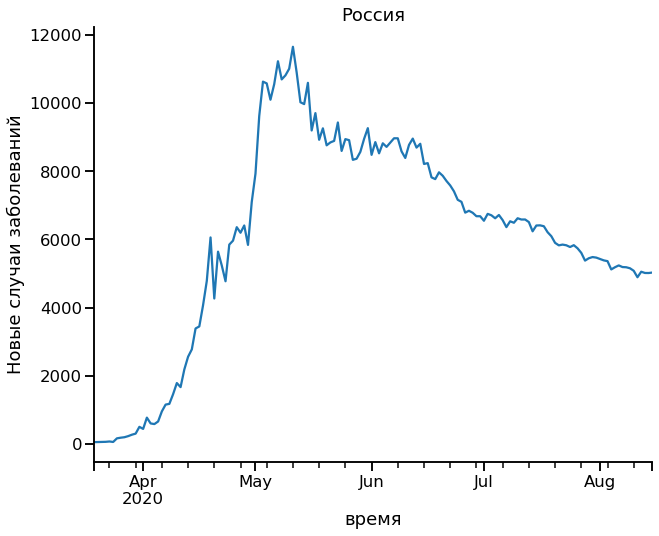

In [6]:
country = "Russia"
df_country = df.loc[lambda x: (x.country == country)].iloc[1:151]

fig, ax = plt.subplots(figsize=(10, 8))
new_cases = df_country.new_cases
new_cases.plot(ax=ax)
ax.set(ylabel="Новые случаи заболеваний", xlabel='время', title='Россия')
sns.despine()

Чтобы запустить модель, мы просто создаем ее экземпляр и вызываем `.sample()`:

In [7]:
gm = GenerativeModel(country, df_country)
model = gm.build()

with model:
    _kwargs = sampler_kwargs()
    prior_pred = pm.sample_prior_predictive()
    trace = pm.sample(**_kwargs)
    post_pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 409 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


[(0.0, 12000.0)]

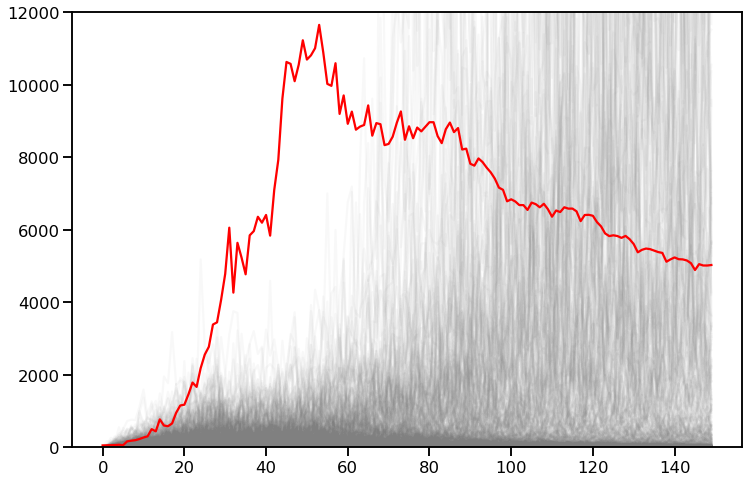

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred["obs"].T, color="0.5", alpha=0.05)
ax.plot(new_cases.values, color="r")
ax.set(ylim=(0, 12_000))

[Text(0.5, 0, 'Days'), Text(0, 0.5, '$R_e(t)$')]

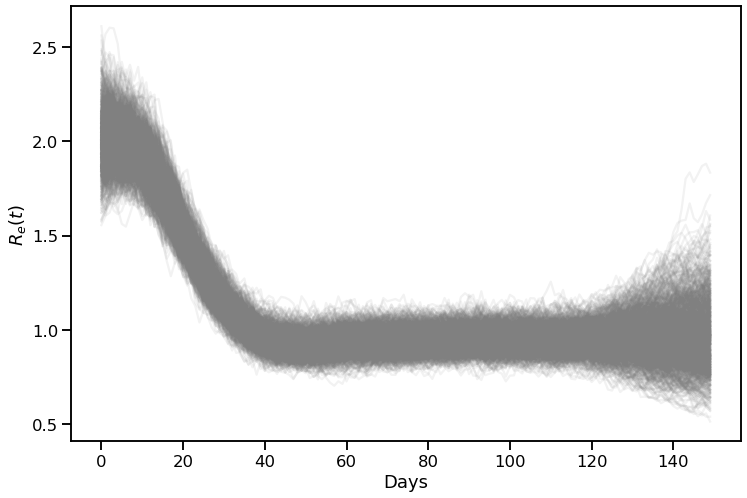

In [9]:
post = trace.posterior["r_t"].sel(chain=0).to_dataframe()["r_t"].unstack().T
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post, color="0.5", alpha=0.1);
ax.set(xlabel="Days", ylabel="$R_e(t)$")

[(0.0, 18000.0)]

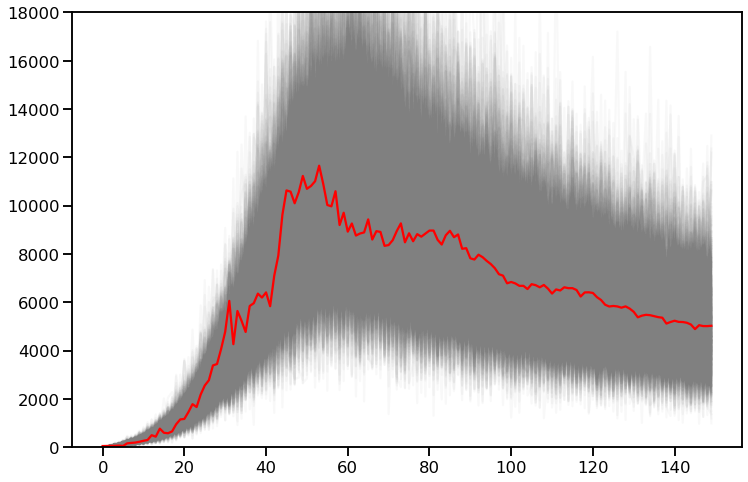

In [10]:
with model:
    post_pred = pm.sample_posterior_predictive(trace)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_pred["obs"].T, color="0.5", alpha=0.05)
ax.plot(new_cases.values, color="r")
ax.set(ylim=(0, 18_000))

`summarize_inference_data()` переформатирует необработанную трассировку выборки, чтобы с ней было легче работать.

In [14]:
result = summarize_inference_data(trace, post_pred, df_country)
result["mean"] = result["mean"].transform(lambda x: x.values)
result["median"] = result["median"].transform(lambda x: x.values)
result["lower_80"] = result["lower_80"].transform(lambda x: x.values)
result["upper_80"] = result["upper_80"].transform(lambda x: x.values)
result["infections"] = result["infections"].transform(lambda x: x.values)
result["test_adjusted_positive"] = result["test_adjusted_positive"].transform(lambda x: x.values)
result["obs"] = result["obs"].transform(lambda x: x.values)

In [15]:
result

mean    median  lower_80  upper_80  infections  \
date                                                             
2020-03-19  2.009239  2.006350  1.818768  2.210203  166.421467   
2020-03-20  2.011467  2.009575  1.816182  2.203496    6.278762   
2020-03-21  2.011506  2.010447  1.834212  2.192468   22.790455   
2020-03-22  2.008885  2.003003  1.838935  2.181978   36.044446   
2020-03-23  2.002530  2.004060  1.842394  2.166985   45.309394   
...              ...       ...       ...       ...         ...   
2020-08-11  0.966177  0.949281  0.765023  1.190121  194.108033   
2020-08-12  0.966887  0.950510  0.759402  1.193499  194.155551   
2020-08-13  0.969335  0.952216  0.762493  1.206289  194.319891   
2020-08-14  0.971644  0.957155  0.758792  1.212931  194.619150   
2020-08-15  0.971833  0.962516  0.756966  1.213746  195.079294   

            test_adjusted_positive          obs  
date                                             
2020-03-19                0.000000  6105.851827  
2020-03-20               19.750115  6105.851827  
2020-03-21               44.374739  6105.851827  
2020-03-22               70.018824  6105.851827  
2020-03-23               97.463676  6105.851827  
...                            ...          ...  
2020-08-11             5101.550572  6105.851827  
2020-08-12             5070.496470  6105.851827  
2020-08-13             5040.805330  6105.851827  
2020-08-14             5012.523284  6105.851827  
2020-08-15             4985.717087  6105.851827  

[150 rows x 7 columns]

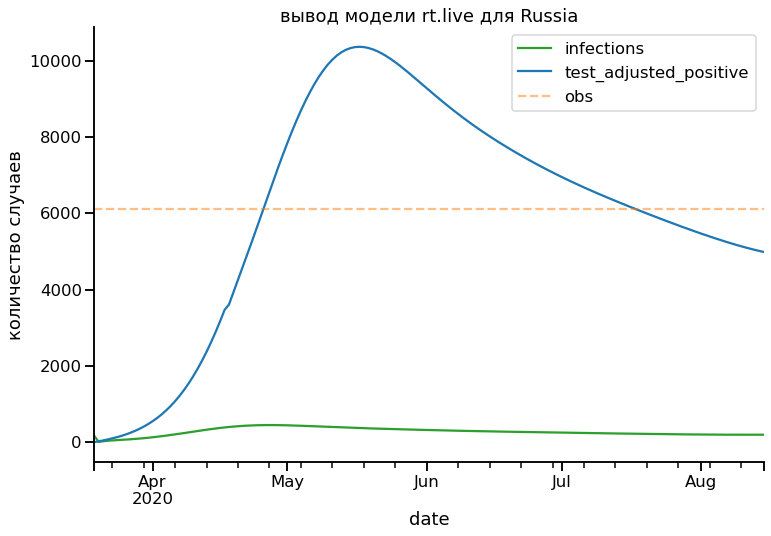

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
result.infections.plot(c="C2", label="infections")
result.test_adjusted_positive.plot(c="C0", label="test_adjusted_positive")
result.obs.plot(c="C1", alpha=0.5, label="obs", style="--")
fig.set_facecolor("w")
ax.legend()
ax.set(title=f"вывод модели rt.live для {country}", ylabel="количество случаев")
sns.despine();

График выше показывает, что именно происходит на каждом этапе. Давайте применим логику в обратном порядке, на этот раз перейдя от данных к скрытым причинам. Во-первых, у нас есть наблюдаемые данные «Сообщенных положительных тестов» серого цвета. Это то, что наша модель пытается объяснить с помощью «Ожидаемых положительных тестов», выходных данных модели, которые выводятся из «Ожидаемого числа положительных тестов, если бы тесты были постоянными». Это число мы сворачиваем с *распределением задержки начала*, чтобы получить из «Начала инфекции», т. е. когда люди фактически заразились. Оттуда мы используем *распределение времени генерации*, чтобы прийти к тому, когда произошла фактическая передача заболевания.

Наша оценка $R_e(t)$ затем основана на том, когда произошла фактическая передача, а не на том, когда мы наблюдали положительный тест:

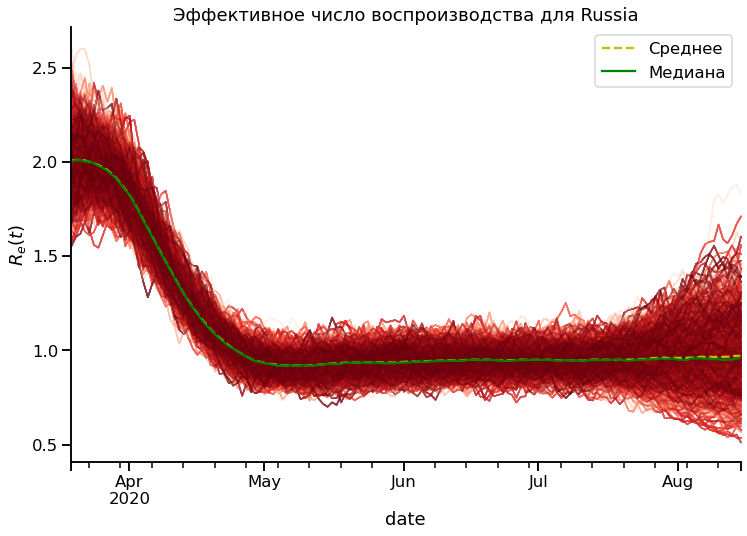

In [18]:
# Предполагается, что 'trace' и 'result' уже определены
fig, ax = plt.subplots(figsize=(12, 8))

# Заголовок и подпись для оси Y
ax.set(title=f"Эффективное число воспроизводства для {country}", ylabel="$R_e(t)$")

# Извлекаем значения из трассировки
samples = trace.posterior["r_t"].values  # Объект с размерностью (1000, 150)
x = result.index  # Индексы из результата
cmap = plt.get_cmap("Reds")  # Цветовая карта
percs = np.linspace(1, 1000, 1000)  # Процентные значения для интервалов
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))  # Нормализация цветов
p_list = [51, 75, 95]

# Рисуем медиану
result["mean"].plot(c="y", ls="--", label='Среднее')
result["median"].plot(c="g", ls="-", label='Медиана')
upper = result.upper_80
lower = result.lower_80

# Перебор процентилей и заполнение области
for p in p_list: 
    for i in range(1000):
        upper = np.percentile(samples, p, axis=0)
        lower = np.percentile(samples, 100 - p, axis=0)
        color_val = colors[i]
        # Заполнение области между upper и lower
        ax.fill_between(x, upper[i], lower[i], color=cmap(color_val), alpha=0.4)

# Настройка внешнего вида графика
sns.despine()
ax.legend()  # Легенда для графика
plt.show()

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy      1.19.5
arviz      0.11.1
pandas     1.1.5
pymc3      3.10.0
platform   1.0.8
seaborn    0.11.2
matplotlib 3.3.4
theano     1.0.11
last updated: Wed Oct 30 2024 

CPython 3.6.15
IPython 7.16.1
watermark 2.0.2
